---
title: Titanic - Machine Learning from Disaster
subtitle: Assignment 1 submission
authors:
  - name: Michael Berger
    email: vo1kod4v@gmail.com
date: 2024/02/20
exports:
  - format: docx
  - format: pdf
    template: arxiv_nips
  - format: pdf
    template: plain_latex
  - format: pdf
    template: frontiers
---

In [1]:
#    template: plain_latex_book
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')=='':
   pass
else:
        
    import sys
    from tempfile import NamedTemporaryFile
    from urllib.request import urlopen
    from urllib.parse import unquote, urlparse
    from urllib.error import HTTPError
    from zipfile import ZipFile
    import tarfile
    import shutil
    
    CHUNK_SIZE = 40960
    DATA_SOURCE_MAPPING = 'titanic:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3136%2F26502%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240427%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240427T185713Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7d5e8fb644f88bb3c1216b99279e5d7b03fdf539c154d3b1bb63bca36941876c5943680cad6834046d3aca8bdf90a32f25d8e90abf44ecdee97f198dca66f58cea19558f6047bd39c10d52b5b8a0d129860f50f1dbf01be349f354894b0fa1b990c5eefe13c64bb89736e535fb4b576a52a03b3c54e52600602e32e99c06046817e9033b88d243372ce7d73d5bcdc3959a95ac635f0605b7fd819bdc32abca86457c5134bfa03b9d8c19d85cdf95d55ad23dfea13c6c3a7cd1698b3c974e8d974190771ce8e7361b7ff82362c2c5531ab1872df3feb7a8c4e698103240f3435816898262816d665ddd64fc05c4692c9a3e87eadaf8250dadd42c2e9fc8eb1d5b'
    
    KAGGLE_INPUT_PATH='/kaggle/input'
    KAGGLE_WORKING_PATH='/kaggle/working'
    KAGGLE_SYMLINK='kaggle'
    
    !umount /kaggle/input/ 2> /dev/null
    shutil.rmtree('/kaggle/input', ignore_errors=True)
    os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
    os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)
    
    try:
      os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
    except FileExistsError:
      pass
    try:
      os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
    except FileExistsError:
      pass
    
    for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
        directory, download_url_encoded = data_source_mapping.split(':')
        download_url = unquote(download_url_encoded)
        filename = urlparse(download_url).path
        destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
        try:
            with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
                total_length = fileres.headers['content-length']
                print(f'Downloading {directory}, {total_length} bytes compressed')
                dl = 0
                data = fileres.read(CHUNK_SIZE)
                while len(data) > 0:
                    dl += len(data)
                    tfile.write(data)
                    done = int(50 * dl / int(total_length))
                    sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                    sys.stdout.flush()
                    data = fileres.read(CHUNK_SIZE)
                if filename.endswith('.zip'):
                  with ZipFile(tfile) as zfile:
                    zfile.extractall(destination_path)
                else:
                  with tarfile.open(tfile.name) as tarfile:
                    tarfile.extractall(destination_path)
                print(f'\nDownloaded and uncompressed: {directory}')
        except HTTPError as e:
            print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
            continue
        except OSError as e:
            print(f'Failed to load {download_url} to path {destination_path}')
            continue
    
    print('Data source import complete.')


In [2]:
!pip install pandasql
#!pip install matplotlib==3.7.0

# Overview

The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

**Data Dictionary**

|Variable|	Definition|	Key|
|----:|:------------:|:------|
|survival|	Survival|	0 = No, 1 = Yes|
|pclass|	Ticket class|	1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|	Sex	|
|Age|	Age in years	|
|sibsp|	# of siblings / spouses aboard the Titanic|
|parch|	# of parents / children aboard the Titanic|
|ticket|	Ticket number	| |
|fare|	Passenger fare	| |
|cabin|	Cabin number	| |
|embarked|	Port of Embarkation|	C = Cherbourg, Q = Queenstown, S = Southampton|

**Variable Notes**

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

# Libraries

In [3]:
# @title
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import plotly.express as px
import plotly.subplots as subplots
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.graph_objects as go

# sklearn imports
from sklearn import metrics
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, cross_val_score
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier

import pandasql as ps

from datetime import datetime
import json
import scipy.stats as st

#%matplotlib inline

pio.templates["my_modification"] = go.layout.Template(
    layout=dict(font={"size": 30})
)
# Then combine your modification with any of the 
# available themes like this:
pio.templates.default = "plotly_white+my_modification"


# Reading Train Data

In [4]:
#if running on kaggle
#pref = '/kaggle/input/titanic/'

# if running on local
pref = ''

In [5]:
passenger_df_train = pd.read_csv(pref+"train.csv", index_col="PassengerId")
passenger_df_test = pd.read_csv(pref+"test.csv", index_col="PassengerId")

passenger_df = pd.concat([passenger_df_train,passenger_df_test])
passenger_df.sample(10)

Survived  Pclass  \
PassengerId                     
765               0.0       3   
1029              NaN       2   
527               1.0       2   
1208              NaN       1   
836               1.0       1   
1150              NaN       2   
1193              NaN       2   
324               1.0       2   
967               NaN       1   
421               0.0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
765                                     Eklund, Mr. Hans Linus    male  16.0   
1029                                       Schmidt, Mr. August    male  26.0   
527                                       Ridsdale, Miss. Lucy  female  50.0   
1208                             Spencer, Mr. William Augustus    male  57.0   
836                                Compton, Miss. Sara Rebecca  female  39.0   
1150                                   Bentham, Miss. Lilian W  female  19.0   
1193                                       Malachard, Mr. Noel    male   NaN   
324          Caldwell, Mrs. Albert Francis (Sylvia Mae Harb...  female  22.0   
967                                         Keeping, Mr. Edwin    male  32.5   
421                                     Gheorgheff, Mr. Stanio    male   NaN   

             SibSp  Parch       Ticket      Fare Cabin Embarked  
PassengerId                                                      
765              0      0       347074    7.7750   NaN        S  
1029             0      0       248659   13.0000   NaN        S  
527              0      0  W./C. 14258   10.5000   NaN        S  
1208             1      0     PC 17569  146.5208   B78        C  
836              1      1     PC 17756   83.1583   E49        C  
1150             0      0        28404   13.0000   NaN        S  
1193             0      0       237735   15.0458     D        C  
324              1      1       248738   29.0000   NaN        S  
967              0      0       113503  211.5000  C132        C  
421              0      0       349254    7.8958   NaN        C

**Which features are categorical?**

These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.

- Categorical: Survived, Sex, and Embarked. Ordinal: Pclass.

**Which features are numerical?**

Which features are numerical? These values change from sample to sample. Within numerical features are the values discrete, continuous, or timeseries based? Among other things this helps us select the appropriate plots for visualization.

- Continous: Age, Fare. Discrete: SibSp, Parch.

**Which features may contain errors or typos?**

- Name feature may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names.

**Check if there any null values**

In [6]:
print(passenger_df_train.isna().any())
print('_'*40)
passenger_df_test.isna().any()

Survived    False
Pclass      False
Name        False
Sex         False
Age          True
SibSp       False
Parch       False
Ticket      False
Fare        False
Cabin        True
Embarked     True
dtype: bool
________________________________________


Pclass      False
Name        False
Sex         False
Age          True
SibSp       False
Parch       False
Ticket      False
Fare         True
Cabin        True
Embarked    False
dtype: bool

# Explatory Data Analysis (EDA) and Data Visualization

## Part 1 - Data Visualization

### Describe Data

In [7]:
passenger_df_train.info()
print('_'*40)
passenger_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null   

In [8]:
passenger_df_train.describe()

Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

In [9]:
print(f'Train: There are {len(passenger_df_train["Ticket"].unique())} unique Ticket names and {len(passenger_df_train["Cabin"].unique())} unique Cabins.')
print(f'Test: There are {len(passenger_df_test["Ticket"].unique())} unique Ticket names and {len(passenger_df_test["Cabin"].unique())} unique Cabins.')

Train: There are 681 unique Ticket names and 148 unique Cabins.
Test: There are 363 unique Ticket names and 77 unique Cabins.


**Which features contain blank, null or empty values?**

These will require correcting.

- Cabin > Age > Embarked features contain a number of null values in that order for the training dataset.
- Cabin > Age are incomplete in case of test dataset.

**What are the data types for various features?**

Helping us during converting goal.

- Seven features are integer or floats. Six in case of test dataset.
- Five features are strings (object).

### Amount of Survivors

In [10]:

def create_pie_chart_of_count(df, column_name):
    df_not_null = df[~df[column_name].isnull()]
    fig = px.pie(df_not_null.groupby([column_name]).size().reset_index(name='count'), 
                 names=column_name, values='count', height=800)
    fig.show()

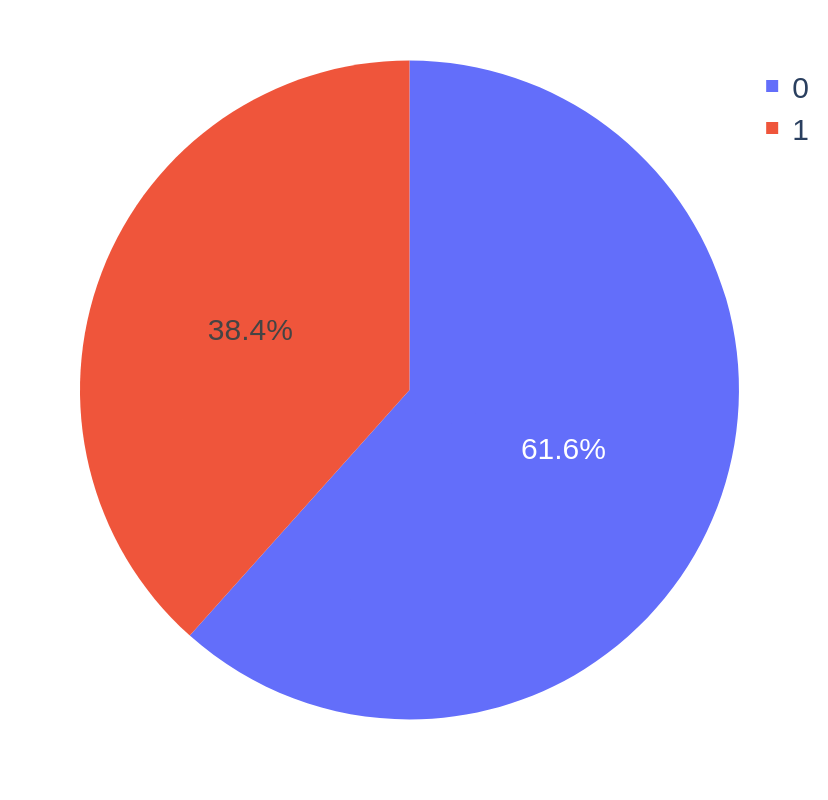

In [11]:
create_pie_chart_of_count(passenger_df_train, 'Survived')

### Pie Charts for Embark, Sex and Pclass

In [12]:
def create_pie_chart_subplot_of_count(df, columns_names):
    rows = int(np.ceil(np.sqrt(len(columns_names))))
    cols = int(np.ceil(len(columns_names)/rows))
    fig = make_subplots(rows=rows, cols=cols, specs=[[{"type": "domain"} for i in range(cols)] for j in range(rows)])
    for i, column_name in enumerate(columns_names):
        df_not_null = df[~df[column_name].isnull()]
        fig.add_trace(go.Pie(labels=df_not_null.groupby([column_name]).size().reset_index(name='count')[column_name],
                             values=df_not_null.groupby([column_name]).size().reset_index(name='count')['count'],
                             name=column_name),
                      (i)//cols+1, (i)%cols+1)
    fig.update_layout(margin=dict(t=10, l=10, r=10, b=10))
    fig.show()

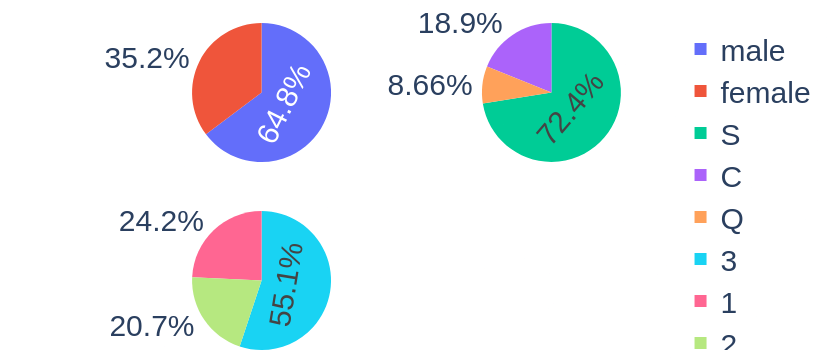

In [13]:
create_pie_chart_subplot_of_count(passenger_df_train, ['Sex', 'Embarked', 'Pclass'])

### Histograms for Siblings/Spouse and Parents/Children

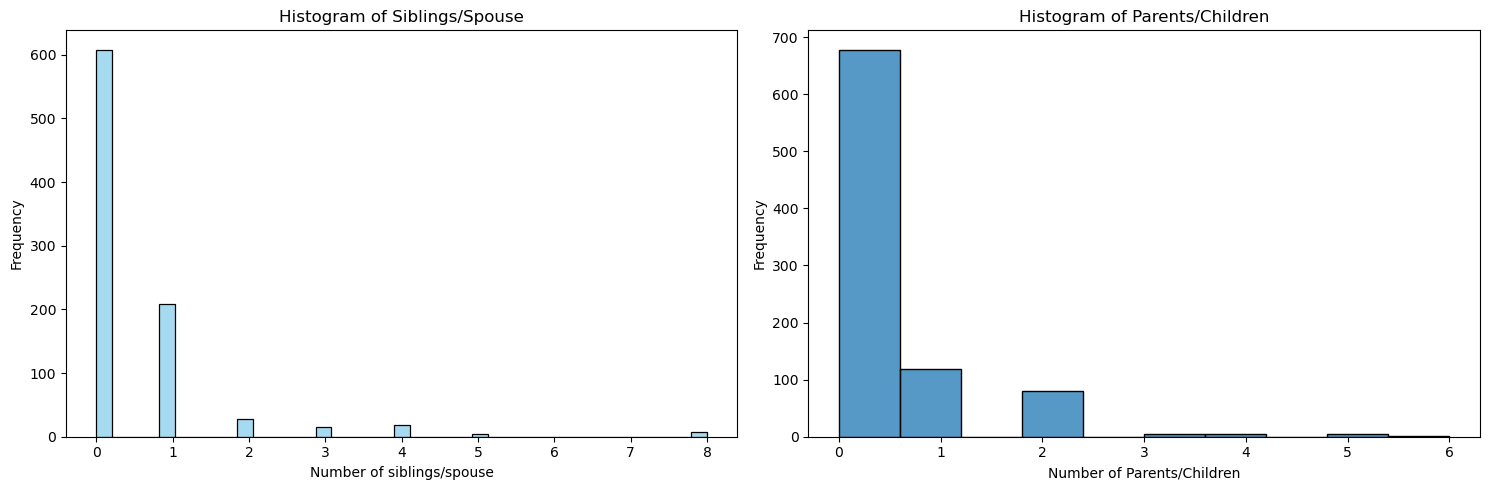

In [14]:
# Create figure and axes objects
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot histograms for 'SibSp', 'Parch', and 'Age'
sns.histplot(passenger_df_train['SibSp'], ax=axs[0], color='skyblue', edgecolor='black', kde=False)
axs[0].set_title('Histogram of Siblings/Spouse')
axs[0].set_xlabel('Number of siblings/spouse')
axs[0].set_ylabel('Frequency')

sns.histplot(passenger_df_train['Parch'], ax=axs[1], edgecolor='black', bins=10, kde=False)
axs[1].set_title('Histogram of Parents/Children')
axs[1].set_xlabel('Number of Parents/Children')
axs[1].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot

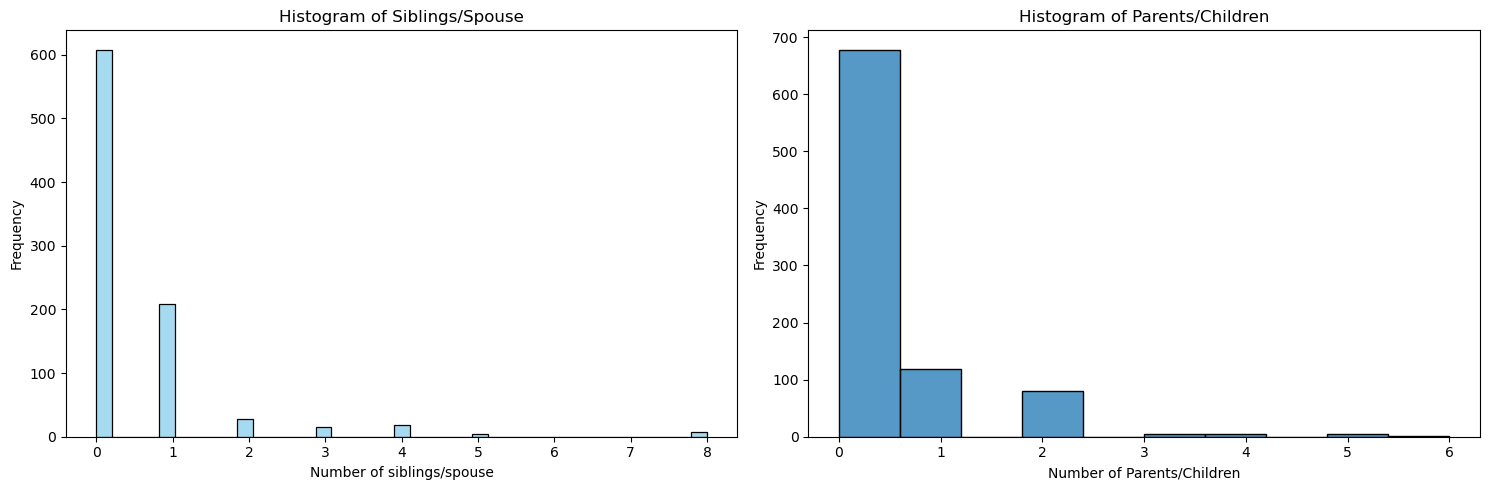

In [15]:
fig

## Observations in a Nutshell for all features seperately:

**passengers**:
1. There were 891 passengers in the data, with 681 unique tickets and 148 Cabins
2. Most passengers did not stay at a Cabin.

**sex**:
1. 65% of passengers are male and the rest female

**survived**:
1. 38% of passengers survived the disaster

**embarked**:
1. The majority of the passengers embarked from Southampton (makes sense because assumed higher population)
2. small amount of passengers have an unknown embarkment

**pclass**:
1. Most of the passengers are 3rd Class

**age**:
1. There are 177 passengers that have an unknown age
2. The average age is 23 and most of the passengers were in their 20's

**sibsp**:
1. 600+ passengers were without siblings/spouses
2. 1 Outlier of 8 siblings/spouse (probably the family members as each index)

**parch**:
1. The big majority of the passengers are without parents/children
2. No big outlier (max=6)
3. Mainly between 0-2

## Assumptions based on the data

**<u>Correlating</u>**

We want to know how well does each feature correlate with Survival.

**<u>Completing</u>**

1. We may want to complete Age feature as it is definitely correlated to survival.
2. We may want to complete the Embarked feature as it may also correlate with survival or another important feature.

**<u>Filtering</u>**

1. Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.
2. Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.
3. PassengerId may be dropped from training dataset as it does not contribute to survival.
4. Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.

**<u>Engineering</u>**

1. We may want to create a new feature called Family based on Parch and SibSp to get total count of family members on board.
2. We may want to engineer the Name feature to extract Title as a new feature.
3. We may want to create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature.
4. We may also want to create a Fare range feature if it helps our analysis.
5. We may want to divide the Cabin into Letter and number of cabin instead of filtering the feature completely to get further information.

**<u>Classifying</u>**

We may also add to our assumptions based on the problem description noted earlier.

1. Women (Sex=female) were more likely to have survived.
2. Children (Age<?) were more likely to have survived.
3. The upper-class passengers (Pclass=1) were more likely to have survived.

## Data Exploration

To confirm some of our observations and assumptions, we can quickly analyze our feature correlations by pivoting features against each other. We can only do so at this stage for features which do not have any empty values. It also makes sense doing so only for features which are categorical (Sex), ordinal (Pclass) or discrete (SibSp, Parch) type.

- **Pclass** We observe significant correlation (>0.5) among Pclass=1 and Survived (classifying #3). We decide to include this feature in our model.
- **Sex** We confirm the observation during problem definition that Sex=female had very high survival rate at 74% (classifying #1).
- **SibSp and Parch** These features have zero correlation for certain values. It may be best to derive a feature or a set of features from these individual features (engineering #1).

### Comparing non-null features to survived

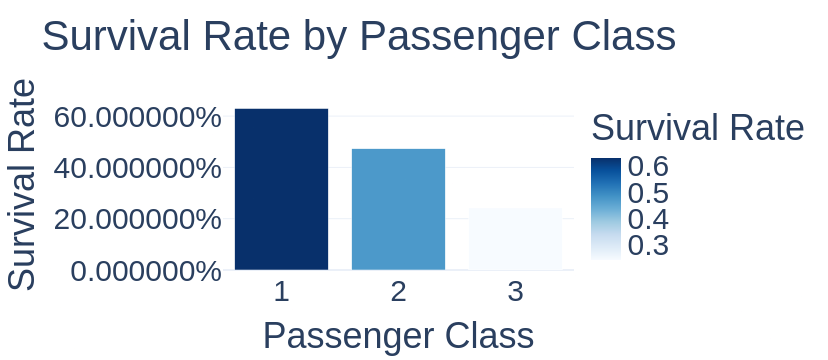

In [16]:
# Your DataFrame and calculation
data = passenger_df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# Create a bar plot using Plotly Express
fig = px.bar(data, x='Pclass', y='Survived', title='Survival Rate by Passenger Class',
             labels={'Pclass': 'Passenger Class', 'Survived': 'Survival Rate'},
             color='Survived', color_continuous_scale='blues')

# Update layout
fig.update_layout(xaxis=dict(tickmode='linear'), yaxis_tickformat='%')

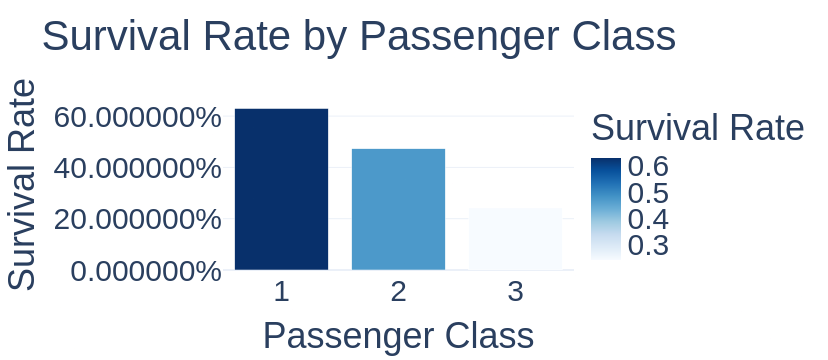

In [17]:
fig.show()

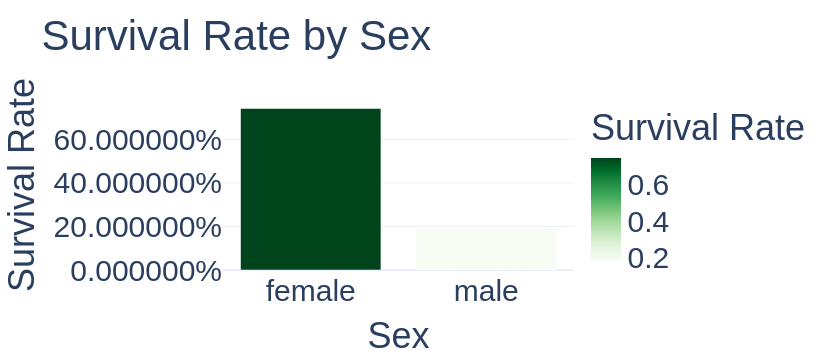

In [18]:
# Your DataFrame and calculation
data = passenger_df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# Create a bar plot using Plotly Express
fig = px.bar(data, x='Sex', y='Survived', title='Survival Rate by Sex',
             labels={'Sex': 'Sex', 'Survived': 'Survival Rate'},
             color='Survived', color_continuous_scale='greens')

# Update layout
fig.update_layout(xaxis=dict(tickmode='linear'), yaxis_tickformat='%')

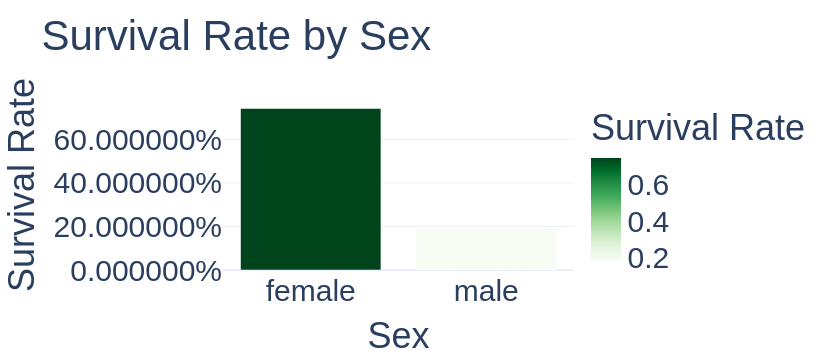

In [19]:
fig.show()

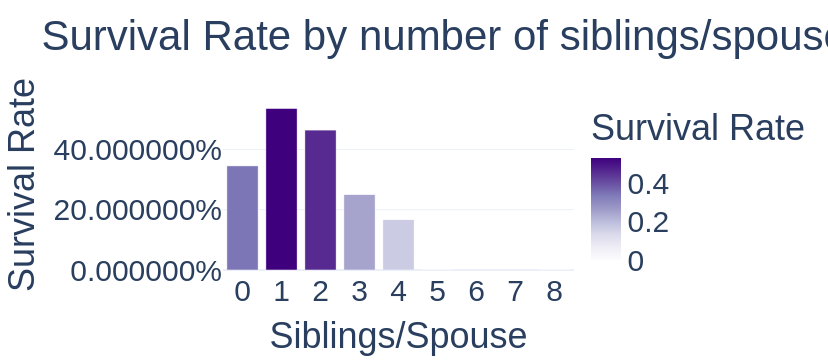

In [20]:
# Your DataFrame and calculation
data = passenger_df_train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# Create a bar plot using Plotly Express
fig = px.bar(data, x='SibSp', y='Survived', title='Survival Rate by number of siblings/spouses',
             labels={'SibSp': 'Siblings/Spouse', 'Survived': 'Survival Rate'},
             color='Survived', color_continuous_scale='purples')

# Update layout
fig.update_layout(xaxis=dict(tickmode='linear'), yaxis_tickformat='%')

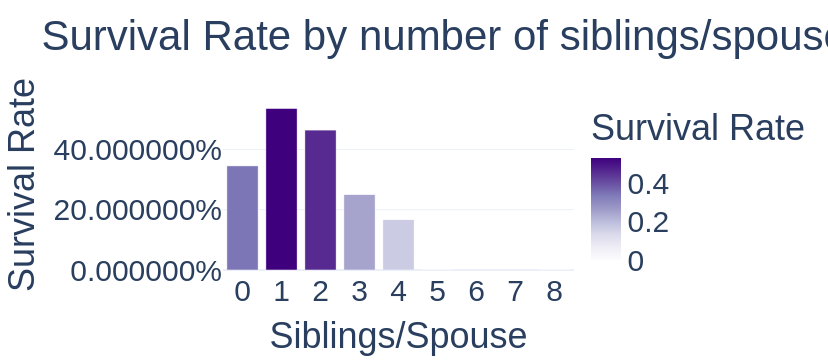

In [21]:
fig.show()

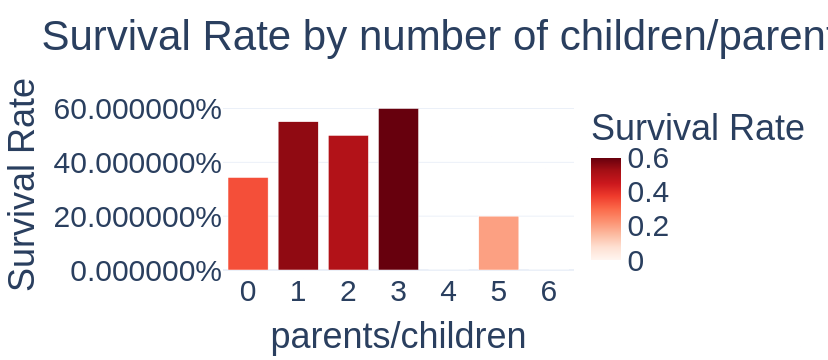

In [22]:
# Your DataFrame and calculation
data = passenger_df_train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# Create a bar plot using Plotly Express
fig = px.bar(data, x='Parch', y='Survived', title='Survival Rate by number of children/parents',
             labels={'Parch': 'parents/children', 'Survived': 'Survival Rate'},
             color='Survived', color_continuous_scale='reds')

# Update layout
fig.update_layout(xaxis=dict(tickmode='linear'), yaxis_tickformat='%')

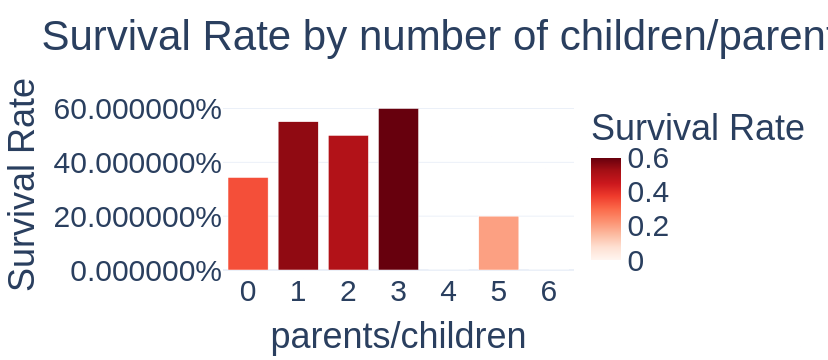

In [23]:
fig.show()

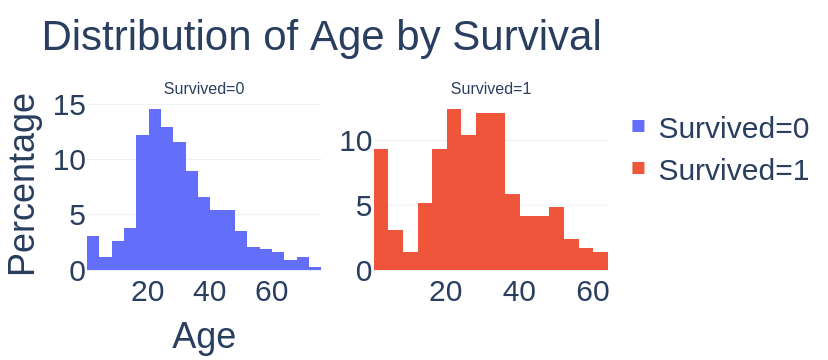

In [24]:
# Define bins for the histogram
bins = np.linspace(passenger_df_train['Age'].min(), passenger_df_train['Age'].max(), 20)

# Create subplots
fig = subplots.make_subplots(rows=1, cols=2, subplot_titles=("Survived=0", "Survived=1"))

# Create histograms for each subplot
for survived_val in [0, 1]:
    age_data = passenger_df_train[passenger_df_train['Survived'] == survived_val]['Age']
    histogram = go.Histogram(x=age_data, histnorm='percent', name=f'Survived={survived_val}', xbins=dict(start=min(bins), end=max(bins), size=(max(bins)-min(bins))/len(bins)))
    fig.add_trace(histogram, row=1, col=survived_val + 1)

# Update layout
fig.update_layout(title_text="Distribution of Age by Survival",
                  xaxis_title="Age",
                  yaxis_title="Percentage",
                  showlegend=True)

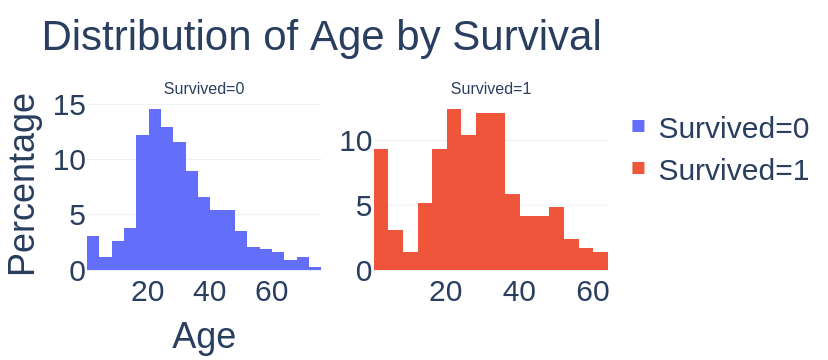

In [25]:
fig.show()

### Based on the Age vs Survived Histograms:

**<u>Observations</u>**

- Infants (Age <=4) had high survival rate.
- Large number of 15-25 year olds did not survive.
- Most passengers are in 15-35 age range.

**<u>Decisions</u>**

- We should consider Age (classifying #2) in our model training.
- Complete the Age feature for null values (completing #1).
- We should band age groups (engineering #3).

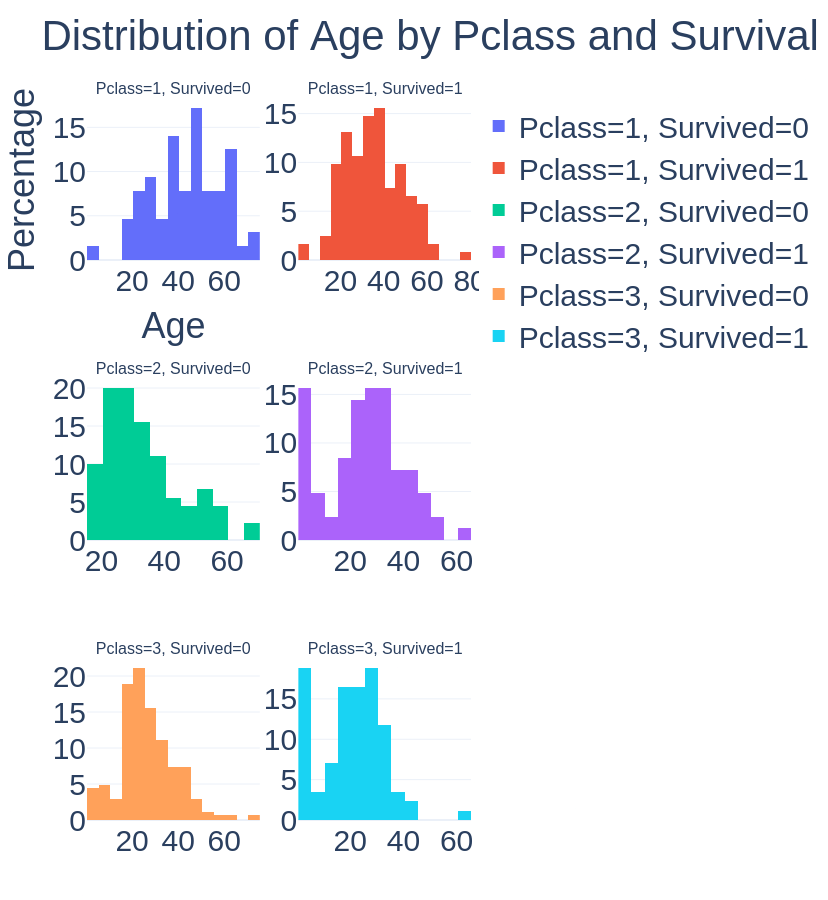

In [26]:
# Create subplots
fig = subplots.make_subplots(rows=3, cols=2, subplot_titles=("Pclass=1, Survived=0", "Pclass=1, Survived=1",
                                                            "Pclass=2, Survived=0", "Pclass=2, Survived=1",
                                                            "Pclass=3, Survived=0", "Pclass=3, Survived=1"))

# Create histograms for each subplot
for pclass_val in [1, 2, 3]:
    for survived_val in [0, 1]:
        age_data = passenger_df_train[(passenger_df_train['Pclass'] == pclass_val) & (passenger_df_train['Survived'] == survived_val)]['Age']
        histogram = go.Histogram(x=age_data, histnorm='percent', name=f'Pclass={pclass_val}, Survived={survived_val}', xbins=dict(start=passenger_df_train['Age'].min(), end=passenger_df_train['Age'].max(), size=5))
        fig.add_trace(histogram, row=pclass_val, col=survived_val + 1)

# Update layout
fig.update_layout(title_text="Distribution of Age by Pclass and Survival",
                  xaxis_title="Age",
                  yaxis_title="Percentage",
                  height=900, width=1000)

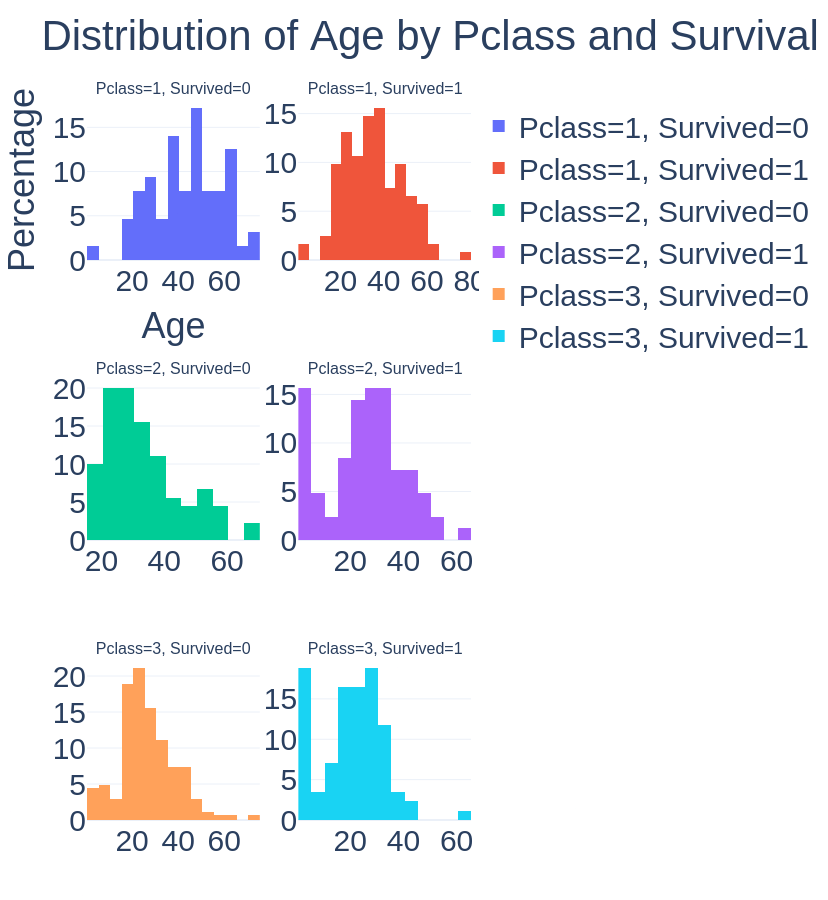

In [27]:
fig.show()

### Based on the Pclass vs Survived Histograms:

**<u>Observations</u>**

- Pclass=3 had most passengers, however most did not survive. Confirms our classifying assumption #2.
- Oldest passengers (Age = 80) survived.
- Infant passengers in Pclass=2 and Pclass=3 mostly survived. Further qualifies our classifying assumption #2.
- Most passengers in Pclass=1 survived. Confirms our classifying assumption #3.
- Pclass varies in terms of Age distribution of passengers.

**<u>Decisions</u>**

- Consider Pclass for model training.

/home/michael/anaconda3/envs/Intelligent/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the pointplot function without specifying `order` is likely to produce an incorrect plot.

/home/michael/anaconda3/envs/Intelligent/lib/python3.11/site-packages/seaborn/axisgrid.py:723: UserWarning:

Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.



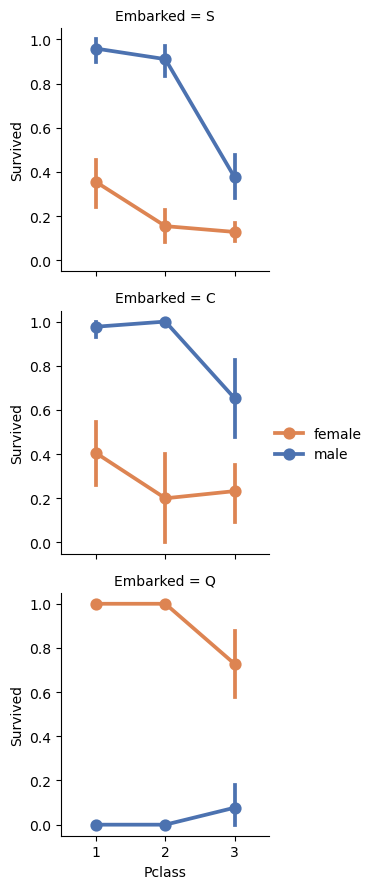

In [28]:
grid = sns.FacetGrid(passenger_df_train, row='Embarked')
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

### Based on the Pclass vs Survived vs Sex based on Embarked pointplots:

**<u>Observations</u>**

- Female passengers had much better survival rate than males. Confirms classifying (#1).
- Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.
- Males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports. Completing (#2).
- Ports of embarkation have varying survival rates for Pclass=3 and among male passengers. Correlating (#1).

**<u>Decisions</u>**

- Add Sex feature to model training.
- Complete and add Embarked feature to model training.

/home/michael/anaconda3/envs/Intelligent/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



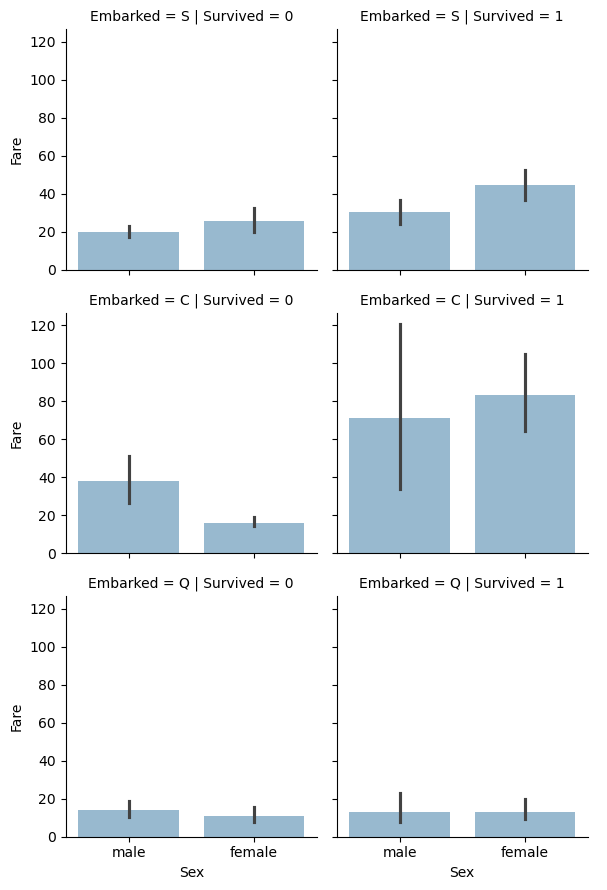

In [29]:
grid = sns.FacetGrid(passenger_df_train, row='Embarked', col='Survived')
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5)
grid.add_legend()

### Based on the Sex vs Fare vs Embarked vs Survived Barplots:

**<u>Observations</u>**

- Higher fare paying passengers had better survival. Confirms our assumption for creating (#4) fare ranges.
- Port of embarkation correlates with survival rates. Confirms correlating (#1) and completing (#2).

**<u>Decisions</u>**

- Consider banding Fare feature.

In [30]:
cabin_divide = passenger_df_train.copy()
cabin_divide['cabin_multiple'] = cabin_divide.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))

# letters
# multiple letters
cabin_divide['cabin_multiple'].value_counts()

cabin_multiple
0    687
1    180
2     16
3      6
4      2
Name: count, dtype: int64

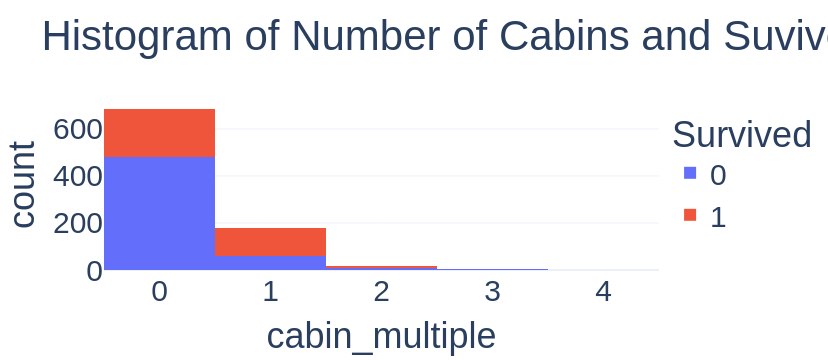

In [31]:
px.histogram(data_frame= cabin_divide, x="cabin_multiple", color="Survived",title='Histogram of Number of Cabins and Suvived')

Create categories based on the cabin letter (n stands for null). In this case we will treat null values like it's own category

In [32]:
cabin_divide['cabin_deck'] = cabin_divide.Cabin.apply(lambda x: str(x)[0])
#comparing survival rate by cabin
print(cabin_divide.cabin_deck.value_counts())

cabin_deck
n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64


In [33]:
pd.pivot_table(cabin_divide,index='Survived',
               columns='cabin_deck', values = 'Name', 
               aggfunc='count')

cabin_deck    A     B     C     D     E    F    G    T      n
Survived                                                     
0           8.0  12.0  24.0   8.0   8.0  5.0  2.0  1.0  481.0
1           7.0  35.0  35.0  25.0  24.0  8.0  2.0  NaN  206.0

### Based on the Cabins Pivot Tables:

**<u>Observations</u>**

- Passengers with at least a Cabin listed to there ticket have a higher chance of surviving. Confirms engineering (#5)
- Cabin titles B,C,D,E and F have a higher chance of survival. Confirms engineering (#5) and debunks Filtering (#2)

**<u>Decisions</u>**

- Consider Seperating the cabin feature into only cabin letters.
- Consider creating a number of Cabins feature.

In [34]:
fig = px.histogram(cabin_divide,
                   facet_col="cabin_deck",
                   x="Pclass",
                   color="Survived",
                   title='Histogram of Pclass vs Cabin Letter vs Who Survived',
                   facet_col_wrap=3,
                   height=800,
                   width=800)

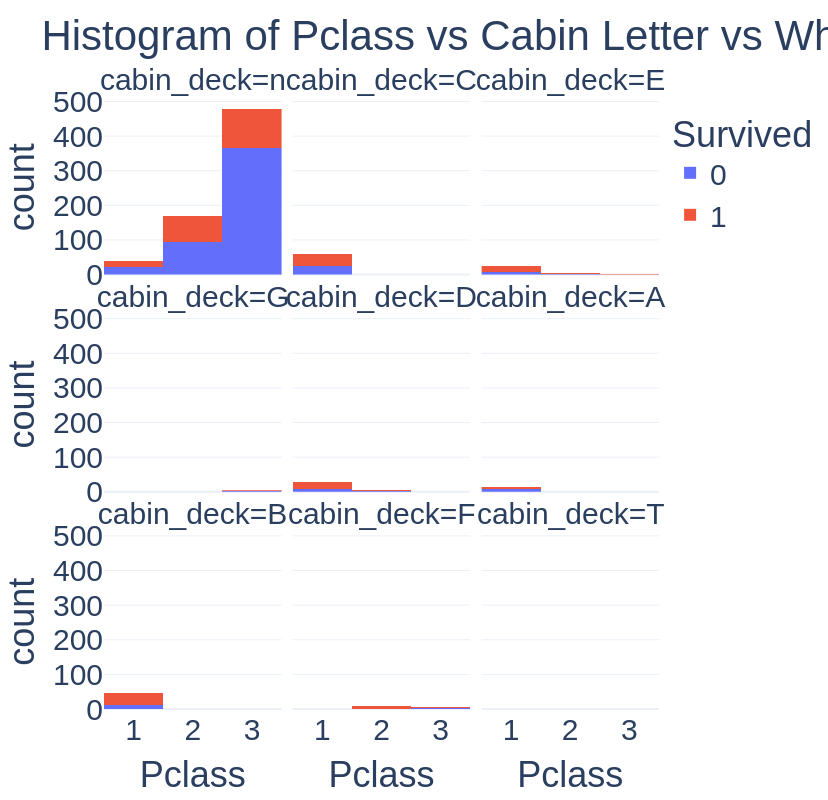

In [35]:
fig.show()

**Ages vs ParCh**

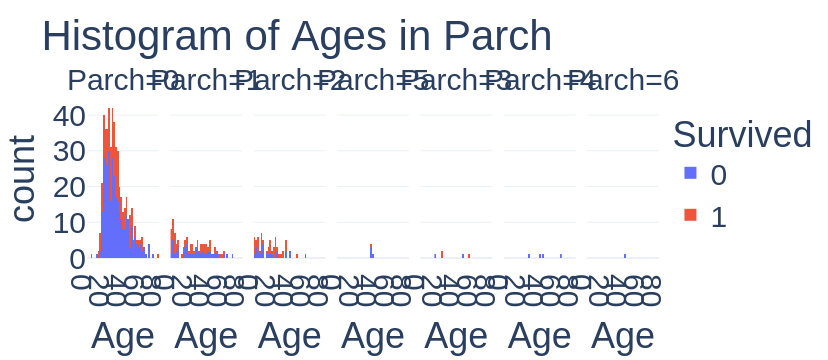

In [36]:
px.histogram(data_frame= passenger_df_train, facet_col="Parch", x="Age", color="Survived",title='Histogram of Ages in Parch')

## Exploration with no regard to Survival
For the purpose of this exploration and feature engineering we will unite training and testing data. The advantage of this is that we can perform same transformations on both datasets at the same time.
Since test set has all NaNs in Survived, we will mark it with "-1". This will later allow for splitting them back easily.  
During this exploration we will not touch "Survived" feature.  

In [37]:
co = {
    "Pclass": [1, 2, 3],
}

In [38]:
passenger_df.loc[passenger_df.Survived.isna(),"Survived"] = -1
passenger_df.sample(10)

Survived  Pclass  \
PassengerId                     
297               0.0       3   
601               1.0       2   
622               1.0       1   
945              -1.0       1   
357               1.0       1   
186               0.0       1   
1262             -1.0       2   
36                0.0       1   
286               0.0       3   
406               0.0       2   

                                                          Name     Sex   Age  \
PassengerId                                                                    
297                                         Hanna, Mr. Mansour    male  23.5   
601          Jacobsohn, Mrs. Sidney Samuel (Amy Frances Chr...  female  24.0   
622                               Kimball, Mr. Edwin Nelson Jr    male  42.0   
945                                 Fortune, Miss. Ethel Flora  female  28.0   
357                                Bowerman, Miss. Elsie Edith  female  22.0   
186                                      Rood, Mr. Hugh Roscoe    male   NaN   
1262                                          Giles, Mr. Edgar    male  21.0   
36                              Holverson, Mr. Alexander Oskar    male  42.0   
286                                        Stankovic, Mr. Ivan    male  33.0   
406                                         Gale, Mr. Shadrach    male  34.0   

             SibSp  Parch  Ticket      Fare        Cabin Embarked  
PassengerId                                                        
297              0      0    2693    7.2292          NaN        C  
601              2      1  243847   27.0000          NaN        S  
622              1      0   11753   52.5542          D19        S  
945              3      2   19950  263.0000  C23 C25 C27        S  
357              0      1  113505   55.0000          E33        S  
186              0      0  113767   50.0000          A32        S  
1262             1      0   28133   11.5000          NaN        S  
36               1      0  113789   52.0000          NaN        S  
286              0      0  349239    8.6625          NaN        C  
406              1      0   28664   21.0000          NaN        S

### Cabin

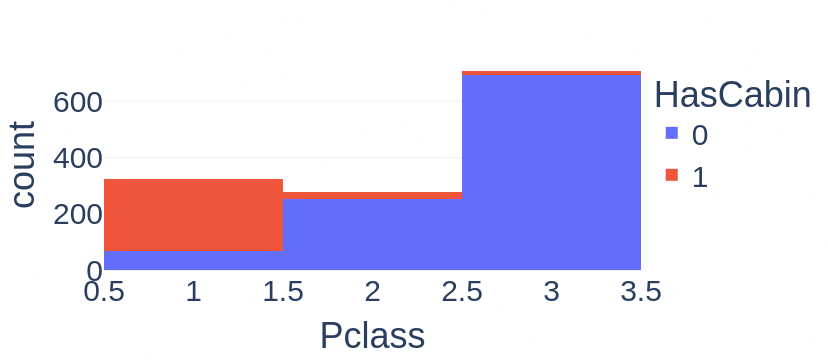

In [39]:
passenger_df["HasCabin"] = ~passenger_df.Cabin.isnull() *1
px.histogram(passenger_df, x = "Pclass", color="HasCabin")

In [40]:
interesting_passengers = [823,  831,  829,  828,  827,  826,  825,  822,  833,
                          584,  938,  600,  285,   24, 1266, 1185,  648,
                          1001, 129, 1180, 1213, 873, 1114, 67, 517, 346]
passenger_df.loc[interesting_passengers].sample(10)


Survived  Pclass                                          Name  \
PassengerId                                                                   
517               1.0       2                  Lemore, Mrs. (Amelia Milley)   
1185             -1.0       1                         Dodge, Dr. Washington   
827               0.0       3                                  Lam, Mr. Len   
584               0.0       1                           Ross, Mr. John Hugo   
833               0.0       3                                Saad, Mr. Amin   
828               1.0       2                         Mallet, Master. Andre   
829               1.0       3                  McCormack, Mr. Thomas Joseph   
600               1.0       1  Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")   
826               0.0       3                               Flynn, Mr. John   
822               1.0       3                             Lulic, Mr. Nikola   

                Sex   Age  SibSp  Parch           Ticket     Fare Cabin  \
PassengerId                                                               
517          female  34.0      0      0       C.A. 34260  10.5000   F33   
1185           male  53.0      1      1            33638  81.8583   A34   
827            male   NaN      0      0             1601  56.4958   NaN   
584            male  36.0      0      0            13049  40.1250   A10   
833            male   NaN      0      0             2671   7.2292   NaN   
828            male   1.0      0      2  S.C./PARIS 2079  37.0042   NaN   
829            male   NaN      0      0           367228   7.7500   NaN   
600            male  49.0      1      0         PC 17485  56.9292   A20   
826            male   NaN      0      0           368323   6.9500   NaN   
822            male  27.0      0      0           315098   8.6625   NaN   

            Embarked  HasCabin  
PassengerId                     
517                S         1  
1185               S         1  
827                S         0  
584                C         1  
833                C         0  
828                C         0  
829                Q         0  
600                C         1  
826                Q         0  
822                S         0

In [41]:
passenger_df.drop("cDeck cNum".split(" "),axis=1, inplace=True, errors='ignore')

#rx = r'(?P<cDeck>[A-Za-z/.]+)?(?P<cNum>\d+)?$'
rx = r'(?P<cDeck>[A-Za-z])(?:\s[A-Za-z])?(?P<cNum>\d+)?$'
tspl = passenger_df.Cabin.str.extract(rx)
passenger_df = passenger_df.join(tspl)

#---
# Why am I doing this step? F deck has slightly different cabins allocation.
# There is an F section in the aft of ship, which starts counting from number
# one again. To make these cabins conform to general structure of cabins
# numbering that I've accepted here, I increase cabin F33 number by 70,
# so the number indicates the cabin is in the aft of ship.
passenger_df.loc[passenger_df.Cabin == "F33","cNum"] = 103
#---


#cabins['cNumRand'] = np.random.randint(1, 140, cabins.shape[0])

passenger_df.loc[passenger_df.Fare.isna(),'Fare'] = 10



#cabins.loc[cabins.cNum.isna(), 'cNum'] = 0  # cabins.loc[cabins.cNum.isna(), 'Fare']
#cabins.cNum = cabins.cNum.astype(int)

#cabins.loc[cabins.cNum.isna(),'cNumRand']
passenger_df.loc[passenger_df.cDeck.isna(),'cDeck'] = 'n'
#passenger_df.loc[passenger_df.Cabin.isna(),'Cabin'] = '?'
#cabins.loc[cabins.tPref.isna(),'tPref'] = '_'




decks = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'n']


passenger_df.cDeck = pd.Categorical(passenger_df.cDeck,
                              categories=decks,
                              ordered=True)



Check that Deck and cabin got split correctly.

In [42]:
passenger_df['cCheck'] =  (passenger_df['cDeck']).astype(str) +  passenger_df['cNum'].astype(str)
passenger_df.loc[passenger_df.cCheck=='nnan',"cCheck"] = np.NaN
check = passenger_df[~(passenger_df['Cabin'] == passenger_df['cCheck'])].sort_values("Cabin")

columns_of_interest =  "Pclass Name Sex Age Fare Cabin cCheck HasCabin cDeck cNum".split(" ")
check.loc[check["HasCabin"]==1, columns_of_interest ]

Pclass                                               Name  \
PassengerId                                                              
680               1                 Cardeza, Mr. Thomas Drake Martinez   
1235              1  Cardeza, Mrs. James Warburton Martinez (Charlo...   
873               1                           Carlsson, Mr. Frans Olof   
1264              1                            Ismay, Mr. Joseph Bruce   
1034              1                         Ryerson, Mr. Arthur Larned   
743               1              Ryerson, Miss. Susan Parker "Suzette"   
956               1                        Ryerson, Master. John Borie   
916               1    Ryerson, Mrs. Arthur Larned (Emily Maria Borie)   
312               1                         Ryerson, Miss. Emily Borie   
300               1    Baxter, Mrs. James (Helene DeLaudeniere Chaput)   
119               1                           Baxter, Mr. Quigg Edmond   
1076              1  Douglas, Mrs. Frederick Charles (Mary Helene B...   
790               1                           Guggenheim, Mr. Benjamin   
803               1                Carter, Master. William Thornton II   
391               1                         Carter, Mr. William Ernest   
436               1                          Carter, Miss. Lucile Polk   
764               1          Carter, Mrs. William Ernest (Lucile Polk)   
298               1                       Allison, Miss. Helen Loraine   
306               1                     Allison, Master. Hudson Trevor   
1198              1               Allison, Mr. Hudson Joshua Creighton   
499               1    Allison, Mrs. Hudson J C (Bessie Waldo Daniels)   
945               1                         Fortune, Miss. Ethel Flora   
961               1                Fortune, Mrs. Mark (Mary McDougald)   
28                1                     Fortune, Mr. Charles Alexander   
439               1                                  Fortune, Mr. Mark   
342               1                     Fortune, Miss. Alice Elizabeth   
89                1                         Fortune, Miss. Mabel Helen   
973               1                                 Straus, Mr. Isidor   
1006              1             Straus, Mrs. Isidor (Rosalie Ida Blun)   
701               1  Astor, Mrs. John Jacob (Madeleine Talmadge Force)   
1094              1                             Astor, Col. John Jacob   
474               2       Jerwan, Mrs. Amin S (Marie Marthe Thuillard)   
1193              2                                Malachard, Mr. Noel   
328               2                            Ball, Mrs. (Ada E Hall)   
293               2                             Levy, Mr. Rene Jacques   
1242              1       Greenfield, Mrs. Leo David (Blanche Strouse)   
98                1                    Greenfield, Mr. William Bertram   
1263              1                          Wilson, Miss. Helen Alice   
1001              2                                  Swane, Mr. George   
1180              3                            Mardirosian, Mr. Sarkis   
1213              3                              Krekorian, Mr. Neshan   
129               3                                  Peter, Miss. Anna   
949               3                      Abelseth, Mr. Olaus Jorgensen   
700               3           Humblen, Mr. Adolf Mathias Nicolai Olsen   
76                3                            Moen, Mr. Sigurd Hansen   
716               3         Soholt, Mr. Peter Andreas Lauritz Andersen   
1114              2                         Cook, Mrs. (Selena Rogers)   
346               2                      Brown, Miss. Amelia "Mildred"   
67                2                       Nye, Mrs. (Elizabeth Ramell)   
517               2                       Lemore, Mrs. (Amelia Milley)   
340               1                       Blackwell, Mr. Stephen Weart   

                Sex    Age      Fare            Cabin cCheck  HasCabin cDeck  \
PassengerI

Some cabins seem to not have splitted correctly. However, upon examining these cabins we can conclude that these are families occupying several cabins. Since the families occupies cabins very close to each other, our splitting is good enough. Those are only in 1st class.

### Ticket/placement
Explore what we can find from ticket/ placement data.  
Columns involved:   
["Fare", "Cabin", "Pclass", "Embarked", "Ticket"]

In [43]:
passenger_df.drop("tPref tNum".split(" "),axis=1, inplace=True, errors='ignore')

rx = r'(?P<tPref>[A-Za-z/.\d]+\s(?:[A-Za-z.\d]+\s)?)?(?P<tNum>\d+)$'

tspl = passenger_df.Ticket.str.extract(rx)
passenger_df = passenger_df.join(tspl)

In [44]:
passenger_df.loc[passenger_df['Ticket'] == "LINE", "tPref"] = "LINE"
passenger_df.loc[passenger_df['Ticket'] == "LINE", "tNum"] = 1
passenger_df.tNum = passenger_df.tNum.astype(int)
passenger_df.loc[passenger_df.tPref.isna(), "tPref"] = ''

Validate: all tickets got split correctly?

In [45]:
passenger_df["tCheck"] =  (passenger_df['tPref']).fillna('') + "" +passenger_df['tNum'].astype(str)
passenger_df[passenger_df['Ticket'] != passenger_df["tCheck"]]

Survived  Pclass                             Name   Sex   Age  \
PassengerId                                                                  
180               0.0       3              Leonard, Mr. Lionel  male  36.0   
272               1.0       3     Tornquist, Mr. William Henry  male  25.0   
303               0.0       3  Johnson, Mr. William Cahoone Jr  male  19.0   
598               0.0       3              Johnson, Mr. Alfred  male  49.0   

             SibSp  Parch Ticket  Fare Cabin Embarked  HasCabin cDeck cNum  \
PassengerId                                                                  
180              0      0   LINE   0.0   NaN        S         0     n  NaN   
272              0      0   LINE   0.0   NaN        S         0     n  NaN   
303              0      0   LINE   0.0   NaN        S         0     n  NaN   
598              0      0   LINE   0.0   NaN        S         0     n  NaN   

            cCheck tPref  tNum tCheck  
PassengerId                            
180            NaN  LINE     1  LINE1  
272            NaN  LINE     1  LINE1  
303            NaN  LINE     1  LINE1  
598            NaN  LINE     1  LINE1

#### Analyzing ticket prefixes

In [46]:
q = """
Select tPref, count(Ticket) as tickets
from passenger_df
group by tPref
order by tickets desc
limit 13
"""
ps.sqldf(q)

tPref  tickets
0                    957
1           PC        92
2         C.A.        46
3   SOTON/O.Q.        16
4        W./C.        14
5    STON/O 2.        14
6          CA.        12
7          A/5        12
8     SC/PARIS        11
9           CA        10
10        A/5.        10
11      F.C.C.         9
12    SOTON/OQ         8

In [47]:
def tr(val):
    val = val.replace(".","")
    val = val.replace("/","")
    val = val.replace(" ","")
    val = val.replace("STON","")
    val = val.replace("SOTON","")
    val = val.replace("PARIS","")
    val = val.replace("Paris","")
    val = val.replace("Basle","")
    val = val.replace("AH","")
    return val


passenger_df['tPrefTr'] = passenger_df.tPref.apply(tr)

prefs = passenger_df.groupby('tPrefTr').count().sort_values('tPrefTr',ascending=True)
co["tPrefTr"]: prefs.index.values
prefs.index.values

array(['', 'A2', 'A4', 'A5', 'AQ3', 'AQ4', 'AS', 'C', 'CA', 'FC', 'FCC',
       'Fa', 'LINE', 'LP', 'O2', 'OQ', 'PC', 'PP', 'PPP', 'SC', 'SCA3',
       'SCA4', 'SCOW', 'SOC', 'SOP', 'SOPP', 'SP', 'SWPP', 'WC', 'WEP'],
      dtype=object)

In [48]:
q = """
select Pclass, tPrefTr, tPref,  count(*) as cnt
from passenger_df
group by Pclass, tPrefTr, tPref
order by Pclass, tPrefTr, cnt desc
limit 13
"""
ps.sqldf(q)

Pclass tPrefTr        tPref  cnt
0        1                       224
1        1      FC        F.C.     3
2        1      PC          PC    92
3        1     WEP        WE/P     2
4        1     WEP      W.E.P.     2
5        2                       184
6        2      CA        C.A.    31
7        2      CA          CA     2
8        2      CA  C.A./SOTON     1
9        2     FCC      F.C.C.     9
10       2     PPP        P/PP     2
11       2      SC    SC/PARIS    11
12       2      SC    SC/Paris     5

Unfortunately, I could not guess what most of these mean, and no clues was found on internet

#### Hypothesis: ticket number has meaning
During exploration I had an hipothesis that ticket number could somehow contain an encoding to placement of the passenger on the ship.
To explore this hypothesis, I created various plots of features that might be involved, such as:
- Ticket number
- Ticket prefix
- Fare
- Class
- Deck
- cabin number

Ticket numbers seem to be concentrated into several groups. Interet seems to suggest that these groups come from individual stores from which the tickets were purchased. The order inside group is probably the order in which the tickets were purchased, so probably not very relevant to current research.

For now I could not identify any interaction pattern of tickets numbers with other features.

Zooming down to only 2, 3 classes, I was wondering if cabin deck, number or side might somehow be "encoded" in Fare and ticket number. But the data is too sparse to make any judjement on that.

In [49]:
passenger_df['ClassDeck'] = passenger_df['Pclass'].astype(str) + passenger_df['cDeck'].astype(str)

co["ClassDeck"] =  passenger_df["ClassDeck"].sort_values(ascending=False).unique()

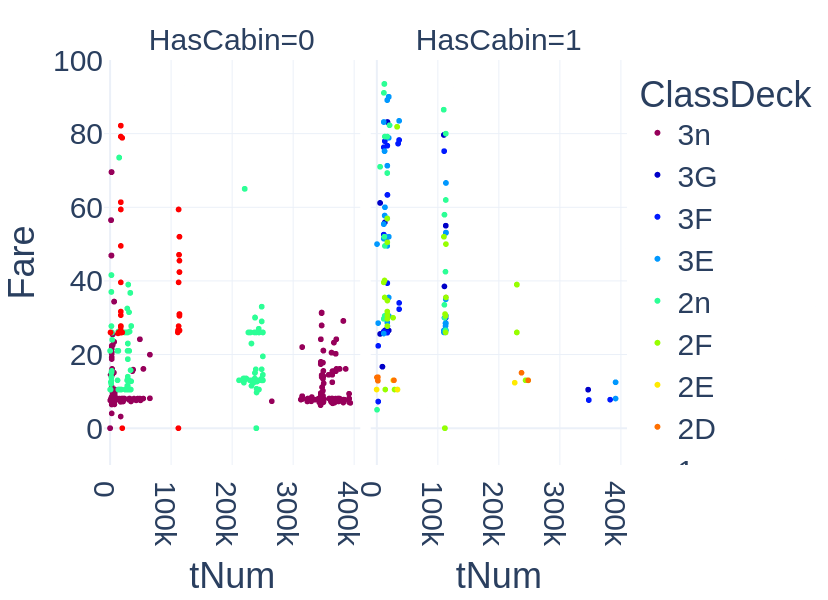

In [50]:
px.scatter(passenger_df, x = "tNum", y = "Fare", color="ClassDeck", facet_col="HasCabin", \
           color_discrete_sequence= px.colors.sequential.Rainbow, category_orders=co ,
           height=600, range_x= [-10000, 4.1e5], range_y=[-10,100]) #, facet_col= "Survived")

### Age

In [51]:
passenger_df[passenger_df.Age.isna()].shape[0] / passenger_df.shape[0]

0.20091673032849502

We see that about 20% of passengers have no age registered. Maybe it could be estimated from other features?

### Name
There appears to be a lot of information that can be extracted from passengers names.  
First, let's see what tokens beside names we can expect to see in this column

In [52]:
def spl(n):
    return  n.split(" ")

In [53]:
names = passenger_df_train.Name.apply(func=spl).values.tolist()
words = sum(names,[])

unique, counts = np.unique(words, return_counts=True)
wc = pd.DataFrame({"word":unique, "count": counts})
wc

tokens = wc.sort_values("count",ascending=False)

In [54]:
tokens.head(20)

word  count
1153        Mr.    517
1122      Miss.    182
1154       Mrs.    125
1633    William     62
858        John     44
1068    Master.     40
758       Henry     33
828       James     24
382     Charles     23
645      George     22
1523     Thomas     21
522      Edward     18
869      Joseph     16
625   Frederick     15
850       Johan     15
226      Arthur     13
1343    Richard     13
1401     Samuel     13
1065       Mary     13
177      Alfred     12

In [55]:
tokens.loc[tokens.word.str.contains("\.", ),"count"].sum()/ passenger_df.shape[0]

0.6814362108479756

We see that people titles have high token frequencies, suggesting that lots of people have them. Specifically, 68% of the people have them.  
Moreover, the Name column appears to have a very consistent structure:  
`Last_name, Title. First_Name (Second_Name)`  
This allows to relatively easy split the Name column into its components.

In [56]:
passenger_df.drop("lName Title fName sName".split(" "),axis=1, inplace=True, errors='ignore')
rx = r"^(?P<lName>[A-Za-z\s'-]+),\s(?P<Title>[A-Za-z\s]+)\.(?:\s(?P<fName>[A-Za-z\s\/\"]+))?(?:\s\((?P<sName>[A-Za-z\s\"'\.-]+)\).*)?$"
nspl = passenger_df.Name.str.extract(rx)
passenger_df = passenger_df.join(nspl)
cols = ['Pclass', 'Name', 'Sex', 'Age', 'lName', 'Title', 'fName', 'sName']

In [57]:
passenger_df[cols].sample(10)

Pclass                              Name     Sex   Age  \
PassengerId                                                           
591               3              Rintamaki, Mr. Matti    male  35.0   
46                3          Rogers, Mr. William John    male   NaN   
49                3               Samaan, Mr. Youssef    male   NaN   
667               2       Butler, Mr. Reginald Fenton    male  25.0   
1288              3              Colbert, Mr. Patrick    male  24.0   
282               3  Olsson, Mr. Nils Johan Goransson    male  28.0   
238               2  Collyer, Miss. Marjorie "Lottie"  female   8.0   
480               3          Hirvonen, Miss. Hildur E  female   2.0   
295               3                  Mineff, Mr. Ivan    male  24.0   
1204              3               Sadowitz, Mr. Harry    male   NaN   

                 lName Title                 fName sName  
PassengerId                                               
591          Rintamaki    Mr                 Matti   NaN  
46              Rogers    Mr          William John   NaN  
49              Samaan    Mr               Youssef   NaN  
667             Butler    Mr       Reginald Fenton   NaN  
1288           Colbert    Mr               Patrick   NaN  
282             Olsson    Mr  Nils Johan Goransson   NaN  
238            Collyer  Miss     Marjorie "Lottie"   NaN  
480           Hirvonen  Miss              Hildur E   NaN  
295             Mineff    Mr                  Ivan   NaN  
1204          Sadowitz    Mr                 Harry   NaN

#### Title

In [58]:
q = """
select Title, count(*) as cnt
from passenger_df
group by Title
order by cnt desc
"""
ps.sqldf(q)

Title  cnt
0             Mr  757
1           Miss  260
2            Mrs  197
3         Master   61
4            Rev    8
5             Dr    8
6            Col    4
7             Ms    2
8           Mlle    2
9          Major    2
10  the Countess    1
11           Sir    1
12           Mme    1
13          Lady    1
14      Jonkheer    1
15          Dona    1
16           Don    1
17          Capt    1

**Most titles are Mr, Mrs, Miss and Master. This may be used to estimate age where it's unknown**

There are several military titles, as well as other relarted to person's occupation. These can be joined into a single category Rare:  
- Col, Major, Jonkeer, Capt.
- Rev is Reverend - a member of clergy  
- Dr is Doctor  

Some titles are the equivalent of Mr, Mrs... in other languages or alternative spelling:  
 - Ms, Mlle = Miss  
 - Mme = Mrs

Several people have a noble title. But since they are few, they can be joined into Mr, Mrs category.  
 - the Countess, Lady, Dona = Mrs  
 - Don, Sir = Mr  


In [59]:
show = "Fare Name Sex Age Pclass lName Title fName sName".split(" ")
show = passenger_df.columns.isin(show)
show

array([False,  True,  True,  True,  True, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True])

In [60]:
passenger_df.loc[passenger_df.Title.isin(["Col", "Major", "Jonkheer", "Capt", "Dr", "Rev"]),show].sort_values("Age")

Pclass                                 Name     Sex   Age  \
PassengerId                                                              
399               2                     Pain, Dr. Alfred    male  23.0   
887               2                Montvila, Rev. Juozas    male  27.0   
849               2                    Harper, Rev. John    male  28.0   
1041              2               Lahtinen, Rev. William    male  30.0   
633               1            Stahelin-Maeglin, Dr. Max    male  32.0   
823               1      Reuchlin, Jonkheer. John George    male  38.0   
1056              2        Peruschitz, Rev. Joseph Maria    male  41.0   
150               2    Byles, Rev. Thomas Roussel Davids    male  42.0   
246               1          Minahan, Dr. William Edward    male  44.0   
537               1    Butt, Major. Archibald Willingham    male  45.0   
1094              1               Astor, Col. John Jacob    male  47.0   
797               1          Leader, Dr. Alice (Farnham)  female  49.0   
661               1        Frauenthal, Dr. Henry William    male  50.0   
151               2           Bateman, Rev. Robert James    male  51.0   
450               1       Peuchen, Major. Arthur Godfrey    male  52.0   
1023              1            Gracie, Col. Archibald IV    male  53.0   
1185              1                Dodge, Dr. Washington    male  53.0   
318               2                 Moraweck, Dr. Ernest    male  54.0   
250               2        Carter, Rev. Ernest Courtenay    male  54.0   
648               1  Simonius-Blumer, Col. Oberst Alfons    male  56.0   
627               2       Kirkland, Rev. Charles Leonard    male  57.0   
695               1                      Weir, Col. John    male  60.0   
746               1         Crosby, Capt. Edward Gifford    male  70.0   
767               1            Brewe, Dr. Arthur Jackson    male   NaN   

                 Fare             lName     Title                  fName  \
PassengerId                                                                
399           10.5000              Pain        Dr                 Alfred   
887           13.0000          Montvila       Rev                 Juozas   
849           33.0000            Harper       Rev                   John   
1041          26.0000          Lahtinen       Rev                William   
633           30.5000  Stahelin-Maeglin        Dr                    Max   
823            0.0000          Reuchlin  Jonkheer            John George   
1056          13.0000        Peruschitz       Rev           Joseph Maria   
150           13.0000             Byles       Rev  Thomas Roussel Davids   
246           90.0000           Minahan        Dr         William Edward   
537           26.5500              Butt     Major   Archibald Willingham   
1094         227.5250             Astor       Col             John Jacob   
797           25.9292            Leader        Dr                  Alice   
661          133.6500        Frauenthal        Dr          Henry William   
151           12.5250           Bateman       Rev           Robert James   
450           30.5000           Peuchen     Major         Arthur Godfrey   
1023          28.5000            Gracie       Col           Archibald IV   
1185          81.8583             Dodge        Dr             Washington   
318           14.0000          Moraweck        Dr                 Ernest   
250           26.0000            Carter       Rev       Ernest Courtenay   
648           35.5000   Simonius-Blumer       Col          Oberst Alfons   
627           12.3500          Kirkland       Rev        Charles Leonard   
695           26.5500              Weir       Col                   John   
746           71.0000            Crosby      Capt         Edward Gifford   
767           39.6000             Brewe        Dr         Arthur Jackson   

               sName  
PassengerId           
399              NaN  
887              NaN  
849              Na

In [61]:
passenger_df.loc[passenger_df.Title.isin(["Col", "Major", "Jonkheer", "Capt", "Dr", "Rev"]), "Title"] = "Rare"
passenger_df.loc[passenger_df.Title.isin(["Mme", "the Countess", "Lady", "Dona"]), "Title"] = "Mrs"
passenger_df.loc[passenger_df.Title.isin(["Ms", "Mlle"]), "Title"] = "Miss"
passenger_df.loc[passenger_df.Title.isin(["Don", "Sir"]), "Title"] = "Mr"

After the replacing we have just 5 categories in title:

In [62]:
q = """
select Title, count(*) as cnt
from passenger_df
group by Title
order by cnt desc
"""
ps.sqldf(q)

Title  cnt
0      Mr  759
1    Miss  264
2     Mrs  201
3  Master   61
4    Rare   24

#### Second name
Let's explore the second name:

In [63]:
passenger_df.loc[~passenger_df.sName.isna(),show].sample(10)

Pclass                                               Name  \
PassengerId                                                              
508               1      Bradley, Mr. George ("George Arthur Brayton")   
935               2              Corbett, Mrs. Walter H (Irene Colvin)   
831               3            Yasbeck, Mrs. Antoni (Selini Alexander)   
927               3   Katavelas, Mr. Vassilios (Catavelas Vassilios")"   
367               1   Warren, Mrs. Frank Manley (Anna Sophia Atkinson)   
859               3              Baclini, Mrs. Solomon (Latifa Qurban)   
195               1          Brown, Mrs. James Joseph (Margaret Tobin)   
324               2  Caldwell, Mrs. Albert Francis (Sylvia Mae Harb...   
1011              2    Chapman, Mrs. John Henry (Sara Elizabeth Lawry)   
4                 1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   

                Sex   Age     Fare      lName Title           fName  \
PassengerId                                                           
508            male   NaN  26.5500    Bradley    Mr          George   
935          female  30.0  13.0000    Corbett   Mrs        Walter H   
831          female  15.0  14.4542    Yasbeck   Mrs          Antoni   
927            male  18.5   7.2292  Katavelas    Mr       Vassilios   
367          female  60.0  75.2500     Warren   Mrs    Frank Manley   
859          female  24.0  19.2583    Baclini   Mrs         Solomon   
195          female  44.0  27.7208      Brown   Mrs    James Joseph   
324          female  22.0  29.0000   Caldwell   Mrs  Albert Francis   
1011         female  29.0  26.0000    Chapman   Mrs      John Henry   
4            female  35.0  53.1000   Futrelle   Mrs   Jacques Heath   

                               sName  
PassengerId                           
508          "George Arthur Brayton"  
935                     Irene Colvin  
831                 Selini Alexander  
927             Catavelas Vassilios"  
367             Anna Sophia Atkinson  
859                    Latifa Qurban  
195                   Margaret Tobin  
324              Sylvia Mae Harbaugh  
1011            Sara Elizabeth Lawry  
4                      Lily May Peel

We perform a similar token analysis  with these as before

In [64]:
names = passenger_df.sName.astype(str).apply(func=spl).values.tolist()
words = sum(names,[])

unique, counts = np.unique(words, return_counts=True)
wc = pd.DataFrame({"word":unique, "count": counts})
tokens = wc.sort_values("count",ascending=False)
tokens.head(20)

word  count
407        nan   1088
272       Mary     13
117  Elizabeth     12
264      Maria      8
33        Anna      7
106          E      6
36       Annie      5
75   Catherine      5
16         Ada      5
261   Margaret      5
140   Florence      5
24       Alice      4
108      Edith      4
7          "Mr      4
127       Emma      4
270     Martha      4
245     Louise      4
188     Hughes      3
177      Helen      3
80   Charlotte      3

In [65]:
passenger_df.loc[passenger_df.sName.astype(str).str.contains("Mr"),show]

Pclass                                               Name  \
PassengerId                                                              
188               1      Romaine, Mr. Charles Hallace ("Mr C Rolmane")   
200               2             Yrois, Miss. Henriette ("Mrs Harbeck")   
428               2  Phillips, Miss. Kate Florence ("Mrs Kate Louis...   
600               1       Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")   
605               1                    Homer, Mr. Harry ("Mr E Haven")   
706               2     Morley, Mr. Henry Samuel ("Mr Henry Marshall")   
711               1   Mayne, Mlle. Berthe Antonine ("Mrs de Villiers")   
1036              1  Lindeberg-Lind, Mr. Erik Gustaf (Mr Edward Lin...   
1219              1        Rosenshine, Mr. George (Mr George Thorne")"   

                Sex   Age     Fare           lName Title            fName  \
PassengerId                                                                 
188            male  45.0  26.5500         Romaine    Mr  Charles Hallace   
200          female  24.0  13.0000           Yrois  Miss        Henriette   
428          female  19.0  26.0000        Phillips  Miss    Kate Florence   
600            male  49.0  56.9292     Duff Gordon    Mr     Cosmo Edmund   
605            male  35.0  26.5500           Homer    Mr            Harry   
706            male  39.0  26.0000          Morley    Mr     Henry Samuel   
711          female  24.0  49.5042           Mayne  Miss  Berthe Antonine   
1036           male  42.0  26.5500  Lindeberg-Lind    Mr      Erik Gustaf   
1219           male  46.0  79.2000      Rosenshine    Mr           George   

                                           sName  
PassengerId                                       
188                               "Mr C Rolmane"  
200                                "Mrs Harbeck"  
428          "Mrs Kate Louise Phillips Marshall"  
600                                  "Mr Morgan"  
605                                 "Mr E Haven"  
706                          "Mr Henry Marshall"  
711                            "Mrs de Villiers"  
1036                          Mr Edward Lingrey"  
1219                           Mr George Thorne"

Seems like majority of these contain full/maiden names of women travelling with ticket under their husbands' names.  
Maybe this property could be used for Age estimation...

### Family composition data

In [66]:
passenger_df["SexClass"] =  passenger_df["Pclass"].astype(str) + passenger_df["Sex"]

co["SexClass"] = passenger_df["SexClass"].sort_values().unique()
co["Parch"] = [0,1,2,3,4,5,6,7,8,9]

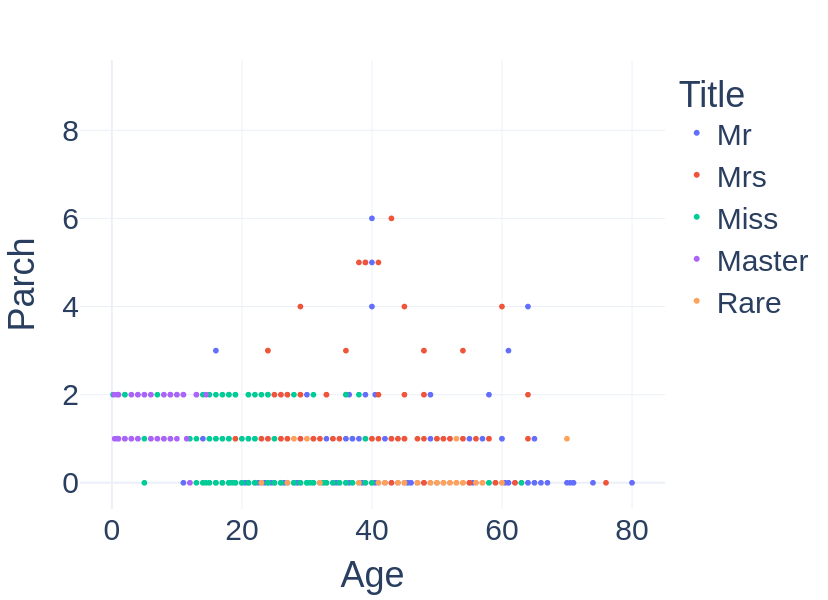

In [67]:
px.scatter(passenger_df, x = "Age", y = "Parch", color="Title", hover_data=["Fare"], \
          category_orders=co, height= 600 )

We clearly see that the titles Master and Miss, along with the amount of parents and siblings, can serve as a good indicator for people's age

### Some interaction variables

In [68]:
passenger_df["EmbClass"] = passenger_df.Pclass.astype(str) + passenger_df.Embarked
co["EmbClass"] = passenger_df["EmbClass"].sort_values().unique()
co["EmbClass"]

array(['1C', '1Q', '1S', '2C', '2Q', '2S', '3C', '3Q', '3S', nan],
      dtype=object)

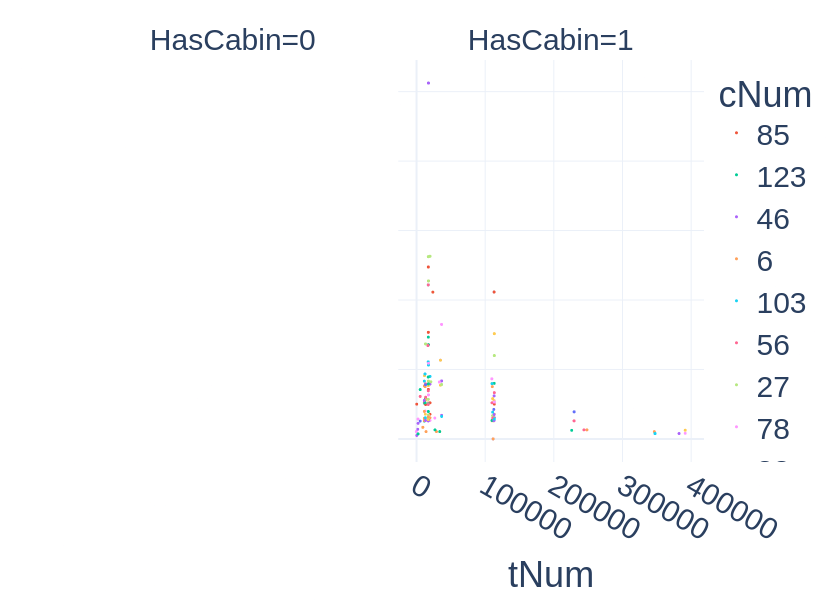

In [69]:

fig = px.scatter(passenger_df, x = "tNum", y = "Fare", color="cNum", facet_col = "HasCabin", \
                 hover_data=[passenger_df.index,"Cabin","Embarked","Fare","Pclass","cNum", "tPrefTr"], \
                 height=600, category_orders=co, \
                 #color_discrete_sequence= px.colors.sequential.Rainbow,\
                 #color_discrete_sequence= cmap,
                )

fig.update_xaxes(categoryorder='category ascending')
fig.update_traces(marker_size = 3)
fig.update_yaxes(tickformat="%f")
fig.update_xaxes(tickformat="%f")

## Part 2 - Data Engineering + Encoding Categorical Values

## Data Imputation

As discussed in Exploration section, about 20% of passengers have no Are registered. We would like to impute the null values of Age with an estimation based on other variables.

But first, there is one person without Fare. We'll just put a number manually there.

In [70]:
passenger_df.loc[passenger_df.Fare.isna(), "Fare"] = 7.2500

Prepare dataset for training and imputation

In [71]:
Cx = ["Fare", "Sex", "SibSp", "Parch", "Pclass", "Title"]
Cy = "Age"
categorical_columns = ["Sex", "Title"]

# Convert categorical variables into dummy variables using one-hot encoding
X = pd.get_dummies(passenger_df[Cx], columns=categorical_columns)
y = passenger_df[Cy]
X.head(7)


Fare  SibSp  Parch  Pclass  Sex_female  Sex_male  \
PassengerId                                                        
1             7.2500      1      0       3       False      True   
2            71.2833      1      0       1        True     False   
3             7.9250      0      0       3        True     False   
4            53.1000      1      0       1        True     False   
5             8.0500      0      0       3       False      True   
6             8.4583      0      0       3       False      True   
7            51.8625      0      0       1       False      True   

             Title_Master  Title_Miss  Title_Mr  Title_Mrs  Title_Rare  
PassengerId                                                             
1                   False       False      True      False       False  
2                   False       False     False       True       False  
3                   False        True     False      False       False  
4                   False       False     False       True       False  
5                   False       False      True      False       False  
6                   False       False      True      False       False  
7                   False       False      True      False       False

Select rows with missing values for 'Age' in target. Those will be imputed

In [72]:
Ximp = X[y.isna()]
yimp = y[y.isna()]
Ximp.head(7)

Fare  SibSp  Parch  Pclass  Sex_female  Sex_male  \
PassengerId                                                         
6              8.4583      0      0       3       False      True   
18            13.0000      0      0       2       False      True   
20             7.2250      0      0       3        True     False   
27             7.2250      0      0       3       False      True   
29             7.8792      0      0       3        True     False   
30             7.8958      0      0       3       False      True   
32           146.5208      1      0       1        True     False   

             Title_Master  Title_Miss  Title_Mr  Title_Mrs  Title_Rare  
PassengerId                                                             
6                   False       False      True      False       False  
18                  False       False      True      False       False  
20                  False       False     False       True       False  
27                  False       False      True      False       False  
29                  False        True     False      False       False  
30                  False       False      True      False       False  
32                  False       False     False       True       False

Select rows with existing values for 'Age' in target. Those will be used to learn the pattern for imputation

In [73]:
X = X[~y.isna()]
y = y[~y.isna()]
X.head(7)

Fare  SibSp  Parch  Pclass  Sex_female  Sex_male  \
PassengerId                                                        
1             7.2500      1      0       3       False      True   
2            71.2833      1      0       1        True     False   
3             7.9250      0      0       3        True     False   
4            53.1000      1      0       1        True     False   
5             8.0500      0      0       3       False      True   
7            51.8625      0      0       1       False      True   
8            21.0750      3      1       3       False      True   

             Title_Master  Title_Miss  Title_Mr  Title_Mrs  Title_Rare  
PassengerId                                                             
1                   False       False      True      False       False  
2                   False       False     False       True       False  
3                   False        True     False      False       False  
4                   False       False     False       True       False  
5                   False       False      True      False       False  
7                   False       False      True      False       False  
8                    True       False     False      False       False

Train, validation, test split

In [74]:
def i_trn_tst_val(X, test_size=0.1):
    i_trn, i_val =  next(model_selection.ShuffleSplit(test_size=test_size, random_state=42).split(X))
    #i_trn, i_val =  next(model_selection.ShuffleSplit(test_size=2*test_size, random_state=42).split(X.iloc[i_trn]))
    return i_trn, i_val

In [75]:
i_trn, i_val = i_trn_tst_val(X)

### Cross-validate ensemble models
This convenience function will be used for training, evaluation  and summarization  of various ML models.  
At this stage we will concentrate on ensemble family of models

In [76]:
newpath = r'CV_Runs'
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [77]:
def Report(cv_run):
    print("Elapsed Time:", cv_run["elapsed"])
    print("====================")
    print("Best Score: {:.3f}".format(grid.best_score_))
    print("Best Parameters: {}".format(grid.best_params_))

In [78]:
CV_Runs = []
import time

def Run_and_Report(grid, X, y):
    start_time = time.time()
    grid.fit(X.iloc[i_trn], y.iloc[i_trn])
    stop_time = time.time()
    
    params = grid.get_params()
    best = grid.best_estimator_
    cv_run = {
        "timestamp": datetime.now().strftime("%Y-%m-%d_%H-%M-%S"),
        "elapsed": time.strftime("%H:%M:%S",time.gmtime(stop_time - start_time)),
        "estimator": str(params['estimator']),
        "best_params": grid.best_params_,
        "train_score": best.score(X.iloc[i_trn], y.iloc[i_trn]),
        "val_score":   best.score(X.iloc[i_val], y.iloc[i_val]),
        #"test_score":  best.score(X.iloc[i_tst], y.iloc[i_tst]),
        "cv": params['cv'],
        "n_iter": params["n_iter"],
        "n_jobs": params["n_jobs"],
        "CVmethod": type(grid).__name__,
        "param_grid": params['param_distributions'],
        "features": X.columns.tolist(),
        "target": y.name
    }
    CV_Runs.append(cv_run)
    with open(f"CV_Runs/{cv_run['timestamp']}.json", 'w') as f:
        json.dump(cv_run, f, default=lambda x: x.__repr__())
    Report(cv_run)

Random Forest

In [79]:
iterations = 1

In [80]:
rfr = RandomForestRegressor()

param_grid ={'max_depth': st.randint(6, 20),
             'n_estimators': st.randint(10, 500),
             'max_features': np.arange(5, 12),
             'max_leaf_nodes': st.randint(6, 30)}

grid = model_selection.RandomizedSearchCV(rfr,
                    param_grid, cv=10,
                    verbose=1, n_iter=iterations, n_jobs=16 )

Run_and_Report(grid, X, y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Elapsed Time: 00:00:01
Best Score: 0.430
Best Parameters: {'max_depth': 12, 'max_features': 10, 'max_leaf_nodes': 17, 'n_estimators': 225}


AdaBoost

In [81]:
abr = AdaBoostRegressor()
abr.get_params()

param_grid ={
    'learning_rate': st.randint(1, 10),
    'n_estimators': st.randint(10, 500),
}

grid = model_selection.RandomizedSearchCV(abr,
                    param_grid, cv=10,
                    verbose=1, n_iter=iterations, n_jobs=16 )

Run_and_Report(grid, X, y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Elapsed Time: 00:00:01
Best Score: -8.114
Best Parameters: {'learning_rate': 8, 'n_estimators': 469}


GradientBoosting

In [82]:
gbr = GradientBoostingRegressor()
param_grid ={'max_depth': st.randint(6, 20),
             'n_estimators': st.randint(10, 500),
             'max_features': np.arange(5,12),
             'max_leaf_nodes': st.randint(6, 30)}


grid = model_selection.RandomizedSearchCV(gbr,
                    param_grid, cv=10,
                    verbose=1, n_iter=iterations, n_jobs=16 )

Run_and_Report(grid, X, y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Elapsed Time: 00:00:00
Best Score: 0.437
Best Parameters: {'max_depth': 8, 'max_features': 5, 'max_leaf_nodes': 21, 'n_estimators': 40}


In [83]:
CV_df = pd.DataFrame(CV_Runs)
CV_df[['elapsed', 'estimator', 'best_params', 'train_score',
       'val_score', 'cv', 'n_iter']]

elapsed                    estimator  \
0  00:00:01      RandomForestRegressor()   
1  00:00:01          AdaBoostRegressor()   
2  00:00:00  GradientBoostingRegressor()   

                                         best_params  train_score  val_score  \
0  {'max_depth': 12, 'max_features': 10, 'max_lea...     0.512268   0.484298   
1          {'learning_rate': 8, 'n_estimators': 469}    -7.715696 -10.234181   
2  {'max_depth': 8, 'max_features': 5, 'max_leaf_...     0.598518   0.484890   

   cv  n_iter  
0  10       1  
1  10       1  
2  10       1

In [84]:
# TODO: fix this plot

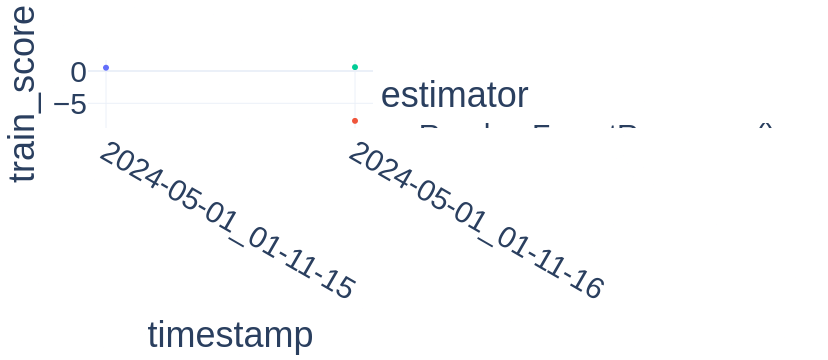

In [85]:
fig = px.scatter(CV_df, x="timestamp", y="train_score", color="estimator")
fig.show()

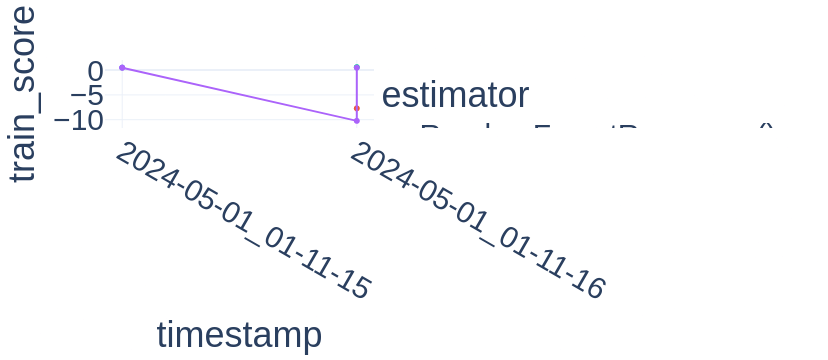

In [86]:
fig.add_trace( go.Scatter(x=CV_df["timestamp"], y=CV_df["val_score"], name="val_score", )) #, fill=CV_df["estimator"]))

fig.show()

### Estimate missing ages
Based on the benchmarking results above, we decided to choose model 3 (GradientBoostingRegressor)

In [87]:
df = CV_df.loc[2,["estimator", "best_params"]]
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    print(df)

estimator                                                        GradientBoostingRegressor()
best_params    {'max_depth': 8, 'max_features': 5, 'max_leaf_nodes': 21, 'n_estimators': 40}
Name: 2, dtype: object


In [88]:
best_params = {'max_depth': 13, 'max_features': 5, 'max_leaf_nodes': 29, 'n_estimators': 435}

rfc = GradientBoostingRegressor( **best_params)
rfc.fit(X,y)
y_hat = rfc.predict(Ximp)
y_hat = pd.Series(rfc.predict(Ximp), index=Ximp.index)
y_hat.head(7)

PassengerId
6     21.991640
18    32.170543
20    44.683260
27    27.389774
29    21.700629
30    27.913384
32    48.778073
dtype: float64

Impute the new predicted age values into original dataset and visually compare distributions of existing and estimated ages

In [89]:
passenger_df.loc[y_hat.index, "Age"] = y_hat.astype(int)
passenger_df["AgeEstimated"] = 0
passenger_df.loc[y_hat.index, "AgeEstimated"] = 1

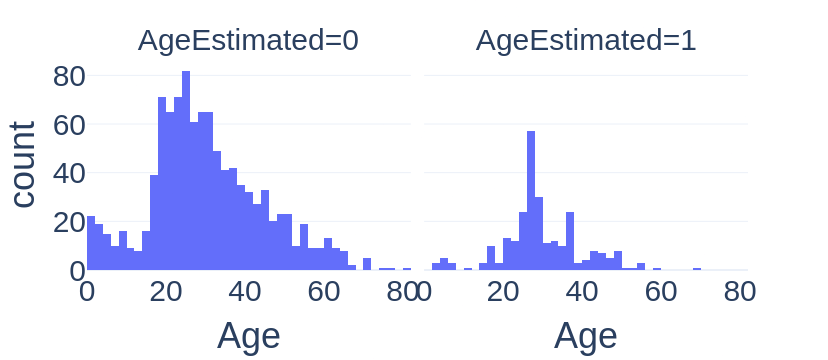

In [90]:
px.histogram(passenger_df, x="Age", facet_col = "AgeEstimated")

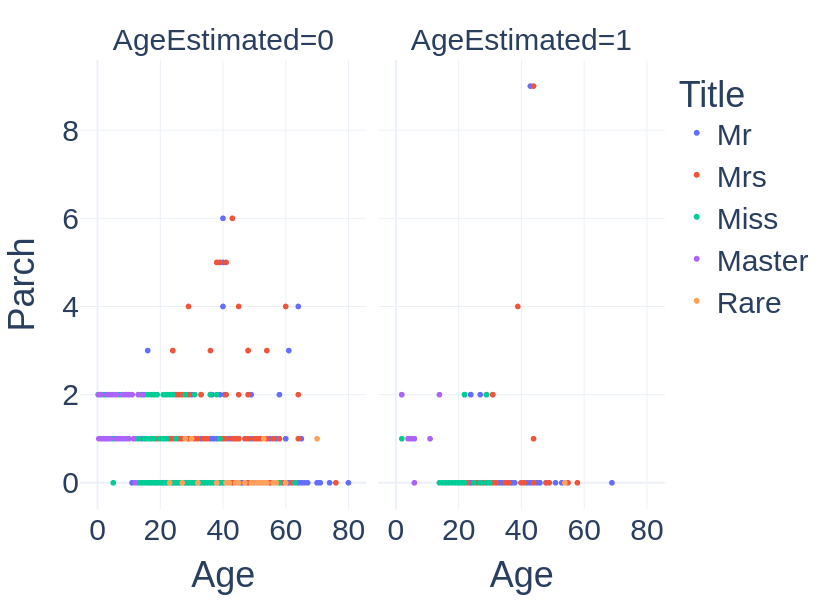

In [91]:
px.scatter(passenger_df, x = "Age", y = "Parch", color="Title", facet_col= "AgeEstimated",
           hover_data=["SibSp", "Fare", "Name"],
           category_orders=co, height= 600)

It seems that imputation went quite well.

## Construct More features

In [92]:
# Gives the length of the name
passenger_df['Words_Count'] = passenger_df['Name'].apply(lambda x: len(x.split()))
print(passenger_df.Words_Count.value_counts())

Words_Count
4     558
3     449
5     144
6      81
7      59
8      16
14      1
9       1
Name: count, dtype: int64


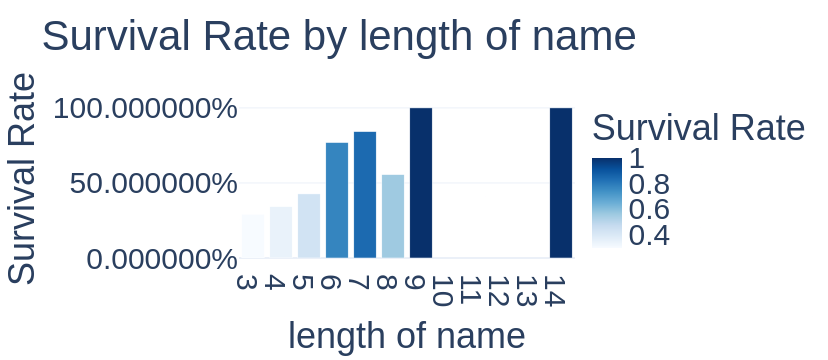

In [93]:
# Your DataFrame and calculation
data = passenger_df[passenger_df.Survived != -1][['Words_Count', 'Survived']].groupby(['Words_Count'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# Create a bar plot using Plotly Express
fig = px.bar(data, x='Words_Count', y='Survived', title='Survival Rate by length of name',
             labels={'Words_Count': 'length of name', 'Survived': 'Survival Rate'},
             color='Survived', color_continuous_scale='blues')

# Update layout
fig.update_layout(xaxis=dict(tickmode='linear'), yaxis_tickformat='%')

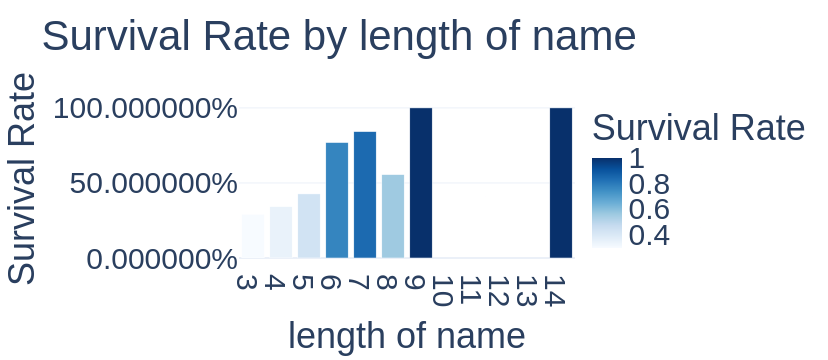

In [94]:
fig.show()

Create new features cabin_multiple and cabin_deck that shows number of cabins each passenger had.  
Create new feature FamilySize as a combination of SibSp and Parch  
Create new feature IsAlone from FamilySize

In [95]:
from IPython.display import HTML

def side_by_side(*dfs):
    html = '<div style="display:flex">'
    for df in dfs:
        html += '<div style="margin-right: 2em">'
        html += df.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))

In [96]:

passenger_df['cabin_multiple'] = passenger_df['Cabin'].apply(
    lambda x: 0 if pd.isna(x) else len(x.split(' ')))
passenger_df['cabin_deck'] = passenger_df['Cabin'].apply(lambda x: str(x)[0])

passenger_df['FamilySize'] = passenger_df['SibSp'] + passenger_df['Parch'] + 1
df1 = passenger_df[passenger_df.Survived != -1][['FamilySize', 'Survived']].groupby(
    ['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

passenger_df['IsAlone'] = 0
passenger_df.loc[passenger_df['FamilySize'] == 1, 'IsAlone'] = 1
df2 = passenger_df[passenger_df.Survived != -1][['IsAlone', 'Survived']].groupby(
    ['IsAlone'], as_index=False).mean().sort_values(by='Survived', ascending=False)


In [97]:
display(df1), display(df2)

FamilySize  Survived
3           4  0.724138
2           3  0.578431
1           2  0.552795
6           7  0.333333
0           1  0.303538
4           5  0.200000
5           6  0.136364
7           8  0.000000
8          11  0.000000

IsAlone  Survived
0        0  0.505650
1        1  0.303538

(None, None)

Remove all NULLS in the Fare column and Create new feature CategoricalFare

In [98]:
passenger_df['Fare'] = passenger_df['Fare'].fillna(passenger_df['Fare'].median())
passenger_df['CategoricalFare'] = pd.qcut(passenger_df['Fare'], 6)
df = passenger_df[passenger_df.Survived != -1][['CategoricalFare', 'Survived']].groupby(
    ['CategoricalFare'], as_index=False).mean().sort_values(
    by='CategoricalFare', ascending=True)

/tmp/ipykernel_2966301/3724020141.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [99]:
df

CategoricalFare  Survived
0  (-0.001, 7.775]  0.205128
1   (7.775, 8.662]  0.190789
2  (8.662, 14.454]  0.366906
3   (14.454, 26.0]  0.436242
4     (26.0, 53.1]  0.435065
5  (53.1, 512.329]  0.695035

Impute missing Age values with random

In [100]:

#age_avg = passenger_df_train['Age'].mean()
#age_std = passenger_df_train['Age'].std()
#age_null_count = passenger_df_train['Age'].isnull().sum()
#age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
#age_null_random_list = pd.Series(age_null_random_list, index = passenger_df_train[passenger_df_train['Age'].isnull()].index)

#passenger_df_train["Age"].fillna(age_null_random_list, inplace=True)


Create a New feature CategoricalAge

In [101]:
passenger_df['CategoricalAge'] = pd.qcut(passenger_df['Age'], 6)
df = passenger_df[passenger_df.Survived != -1][['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean().sort_values(by='CategoricalAge', ascending=True)

/tmp/ipykernel_2966301/2896104425.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [102]:
df.head(8)

CategoricalAge  Survived
0  (0.169, 18.0]  0.503185
1   (18.0, 24.0]  0.347059
2   (24.0, 28.0]  0.320312
3   (28.0, 34.0]  0.366013
4   (34.0, 43.0]  0.388489
5   (43.0, 80.0]  0.368056

## Mapping Categorical and High Ordinal Features

In [103]:

# Mapping Sex
passenger_df['Sex'] = passenger_df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Mapping Titles
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
passenger_df['Title'] = passenger_df['Title'].map(title_mapping)
passenger_df['Title'] = passenger_df['Title'].fillna(0)


# Remove all NULLS in the Embarked column (2 nulls)
passenger_df['Embarked'] = passenger_df['Embarked'].fillna('S')
# Mapping Embarked
passenger_df['Embarked'] = passenger_df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

# Mapping Cabin_adv
passenger_df['cabin_deck'] = passenger_df['cabin_deck'].map( {'n': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8} ).astype(int)

# Mapping Fare
passenger_df.loc[(passenger_df['Fare'] < 6), 'Fare'] = 0
passenger_df.loc[(passenger_df['Fare'] >= 6) & (passenger_df['Fare'] < 12), 'Fare'] = 1
passenger_df.loc[(passenger_df['Fare'] >= 12) & (passenger_df['Fare'] < 18), 'Fare'] = 2
passenger_df.loc[(passenger_df['Fare'] >= 18) & (passenger_df['Fare'] < 24), 'Fare'] = 3
passenger_df.loc[(passenger_df['Fare'] >= 24) & (passenger_df['Fare'] < 30), 'Fare'] = 4
passenger_df.loc[(passenger_df['Fare'] >= 30), 'Fare'] = 5
passenger_df['Fare'] = passenger_df['Fare'].astype(int)

# Mapping Age
passenger_df.loc[ passenger_df['Age'] < 18, 'Age'] 					       = 0
passenger_df.loc[(passenger_df['Age'] >= 18) & (passenger_df['Age'] < 23), 'Age'] = 1
passenger_df.loc[(passenger_df['Age'] >= 23) & (passenger_df['Age'] < 28), 'Age'] = 2
passenger_df.loc[(passenger_df['Age'] >= 28) & (passenger_df['Age'] < 34), 'Age'] = 3
passenger_df.loc[(passenger_df['Age'] >= 34) & (passenger_df['Age'] < 42), 'Age'] = 4
passenger_df.loc[ passenger_df['Age'] >= 42, 'Age'] = 5 ;

passenger_df['Age*Class'] = passenger_df.Age * passenger_df.Pclass

In [104]:
passenger_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

Age*Class  Age  Pclass
PassengerId                        
1                  3.0  1.0       3
2                  4.0  4.0       1
3                  6.0  2.0       3
4                  4.0  4.0       1
5                 12.0  4.0       3
6                  3.0  1.0       3
7                  5.0  5.0       1
8                  0.0  0.0       3
9                  6.0  2.0       3
10                 0.0  0.0       2

## Feature Selection

In [105]:
# Feature selection
drop_elements = ['Name', 'Ticket', 'Cabin', 'SibSp','HasCabin', 'AgeEstimated',
                 'cDeck', 'cNum', 'cCheck', 'tPref', 'tNum', 'tCheck', 'tPrefTr',
                 'ClassDeck', 'lName', 'Title', 'fName', 'sName', 'SexClass', 'EmbClass',]
#drop_elements = ['has_cabin', 'AgeEstimated']
passenger_df = passenger_df.drop(drop_elements, axis = 1, errors='ignore')
passenger_df = passenger_df.drop(['CategoricalAge', 'CategoricalFare'], axis = 1, errors='ignore')

In [106]:
passenger_df.head(10)

Survived  Pclass  Sex  Age  Parch  Fare  Embarked  Words_Count  \
PassengerId                                                                   
1                 0.0       3    1  1.0      0     1         0            4   
2                 1.0       1    0  4.0      0     5         1            7   
3                 1.0       3    0  2.0      0     1         0            3   
4                 1.0       1    0  4.0      0     5         0            7   
5                 0.0       3    1  4.0      0     1         0            4   
6                 0.0       3    1  1.0      0     1         2            3   
7                 0.0       1    1  5.0      0     5         0            4   
8                 0.0       3    1  0.0      1     3         0            4   
9                 1.0       3    0  2.0      2     1         0            7   
10                1.0       2    0  0.0      0     5         1            5   

             cabin_multiple  cabin_deck  FamilySize  IsAlone  Age*Class  
PassengerId                                                              
1                         0           0           2        0        3.0  
2                         1           3           2        0        4.0  
3                         0           0           1        1        6.0  
4                         1           3           2        0        4.0  
5                         0           0           1        1       12.0  
6                         0           0           1        1        3.0  
7                         1           5           1        1        5.0  
8                         0           0           5        0        0.0  
9                         0           0           3        0        6.0  
10                        0           0           2        0        0.0

In [107]:
passenger_df_train = passenger_df[passenger_df.Survived != -1]
passenger_df_train.head(10)

Survived  Pclass  Sex  Age  Parch  Fare  Embarked  Words_Count  \
PassengerId                                                                   
1                 0.0       3    1  1.0      0     1         0            4   
2                 1.0       1    0  4.0      0     5         1            7   
3                 1.0       3    0  2.0      0     1         0            3   
4                 1.0       1    0  4.0      0     5         0            7   
5                 0.0       3    1  4.0      0     1         0            4   
6                 0.0       3    1  1.0      0     1         2            3   
7                 0.0       1    1  5.0      0     5         0            4   
8                 0.0       3    1  0.0      1     3         0            4   
9                 1.0       3    0  2.0      2     1         0            7   
10                1.0       2    0  0.0      0     5         1            5   

             cabin_multiple  cabin_deck  FamilySize  IsAlone  Age*Class  
PassengerId                                                              
1                         0           0           2        0        3.0  
2                         1           3           2        0        4.0  
3                         0           0           1        1        6.0  
4                         1           3           2        0        4.0  
5                         0           0           1        1       12.0  
6                         0           0           1        1        3.0  
7                         1           5           1        1        5.0  
8                         0           0           5        0        0.0  
9                         0           0           3        0        6.0  
10                        0           0           2        0        0.0

In [108]:
passenger_df_test = passenger_df[passenger_df.Survived == -1].drop("Survived", axis=1)
passenger_df_test.head(10)

Pclass  Sex  Age  Parch  Fare  Embarked  Words_Count  \
PassengerId                                                         
892               3    1  4.0      0     1         2            3   
893               3    0  5.0      0     1         0            5   
894               2    1  5.0      0     1         2            4   
895               3    1  2.0      0     1         0            3   
896               3    0  1.0      1     2         0            6   
897               3    1  0.0      0     1         0            4   
898               3    0  3.0      0     1         2            3   
899               2    1  2.0      1     4         0            4   
900               3    0  1.0      0     1         1            6   
901               3    1  1.0      0     4         0            4   

             cabin_multiple  cabin_deck  FamilySize  IsAlone  Age*Class  
PassengerId                                                              
892                       0           0           1        1       12.0  
893                       0           0           2        0       15.0  
894                       0           0           1        1       10.0  
895                       0           0           1        1        6.0  
896                       0           0           3        0        3.0  
897                       0           0           1        1        0.0  
898                       0           0           1        1        9.0  
899                       0           0           3        0        4.0  
900                       0           0           1        1        3.0  
901                       0           0           3        0        3.0

In [109]:
passenger_df_corr=passenger_df_train.astype(float).corr()

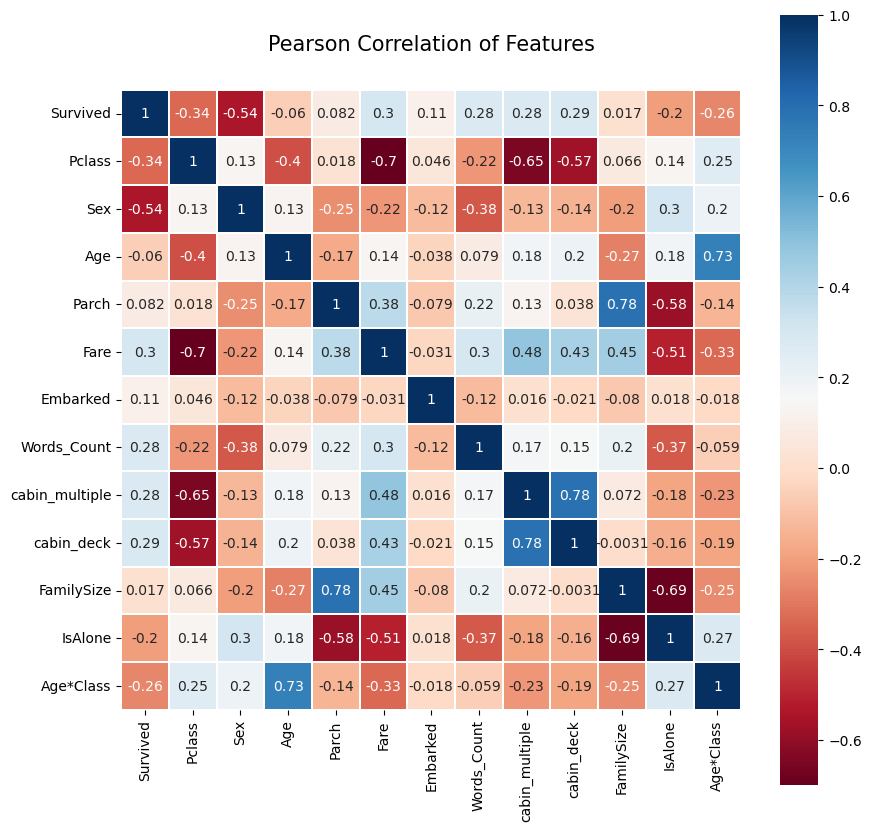

In [110]:
colormap=plt.cm.RdBu
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(passenger_df_corr,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

## Takeaway from the Heatmap

There aren't many features strongly correlated with one another (highest is 0.78 between Parch and FamilySize and between the two cabin features. We'll still leave both features.) This is good from a point of view of feeding these features into your learning model because there isn't much redundant or superfluous data in our training set and we accept that each feature carries data with some unique information.

# Model Learning

## Splitting the passenger data 80/20

In [111]:
X = passenger_df_train.drop('Survived', axis=1)
y = passenger_df_train['Survived']

# Splitting data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Functions

### Train and Evaluate models

In [112]:
def train_and_evaluate_models(models, X_train, y_train, X_val, y_val, param_grids, scoring='accuracy', cv=10):
    results = {}
    evaluation_data = []  # Create a list to store evaluation data

    for model_name, model in models.items():
        param_grid = param_grids[model_name]

        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=cv)
        grid_search.fit(X_train, y_train)

        params = grid_search.cv_results_['params']
        scores = grid_search.cv_results_['mean_test_score']

        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        model.set_params(**best_params)
        model.fit(X_train, y_train)

        validation_score = model.score(X_val, y_val)

        results[model_name] = {
            'best_params': best_params,
            'best_score': best_score,
            'validation_score': validation_score
        }

        # Append evaluation data as a dictionary to the list
        evaluation_data.append({
            'Model': model_name,
            'Best Parameters': best_params,
            'Best Score (CV)': best_score,
            'Validation Score': validation_score
        })
        visualize_grid_search_results(param_grid, params, scores, best_params, best_score, model_name)
    # Create a DataFrame from the list of evaluation data
    evaluation_df = pd.DataFrame(evaluation_data)

    return results, evaluation_df

### Visualize Results

In [113]:
def visualize_grid_search_results(param_grid, params, scores, best_params, best_score,title=''):
    plt.figure(figsize=(18, 12))

    for i, param_name in enumerate(param_grid.keys()):
        plt.subplot(2, 2, i + 1)
        param_values = [param[param_name] for param in params]
        plt.plot(param_values, scores, marker='o')
        plt.xlabel(param_name)
        plt.ylabel('Mean Test Score')
        plt.title('Grid Search CV Results for {}{}'.format(param_name, ' - ' + title if title else ''))
        plt.grid(True)

        # Marking the best parameter value
        best_value = best_params[param_name]
        plt.scatter(best_value, best_score, color='red', label='Best: {} = {:.2f}'.format(param_name, best_value))
        plt.annotate('Best: {} = {:.2f}'.format(param_name, best_value), xy=(best_value, best_score), xytext=(best_value, best_score + 0.02),
                     arrowprops=dict(facecolor='black', arrowstyle='->'), horizontalalignment='center')
        plt.legend()

    plt.tight_layout()
    plt.show()

### Confusion Matrix for Best Model

In [114]:
def evaluate_best_model(best_model, X_train, y_train, X_val, y_val):
    train_predictions = best_model.predict(X_train)
    val_predictions = best_model.predict(X_val)

    train_accuracy = accuracy_score(y_train, train_predictions)
    val_accuracy = accuracy_score(y_val, val_predictions)

    conf_matrix = confusion_matrix(y_val, val_predictions)

    precision = precision_score(y_val, val_predictions)
    recall = recall_score(y_val, val_predictions)
    f1 = f1_score(y_val, val_predictions)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.text(0.5, 1.15, f"Precision: {precision:.2f}\nRecall: {recall:.2f}\nF1-score: {f1:.2f}",
             horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.tight_layout()
    plt.show()

    print("Train Accuracy: {:.4f}".format(train_accuracy))
    print("Validation Accuracy: {:.4f}".format(val_accuracy))

    return train_accuracy, val_accuracy, precision, recall, f1

## Initialize models with Hyperparameters

In [115]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    #'Lasso': Lasso(),
    #'Ridge': Ridge(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# Define hyperparameter grids for each model
param_grids = {
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Random Forest': {'n_estimators': [10, 50, 100, 200, 500], 'max_depth': [None, 10, 20, 30, 50]},
    'SVM': {'C': [0.01, 0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10, 100]},
    'Gradient Boosting': {'n_estimators': [10, 50, 100, 200, 500], 'learning_rate': [0.001, 0.01, 0.1, 1]},
    'Decision Tree': {'max_depth': [None, 10, 20, 30, 50, 100]}
    #'Lasso': {'alpha': [0.01, 0.1, 1]},
    #'Ridge': {'alpha': [0.01, 0.1, 1]},
}

/home/michael/anaconda3/envs/Intelligent/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



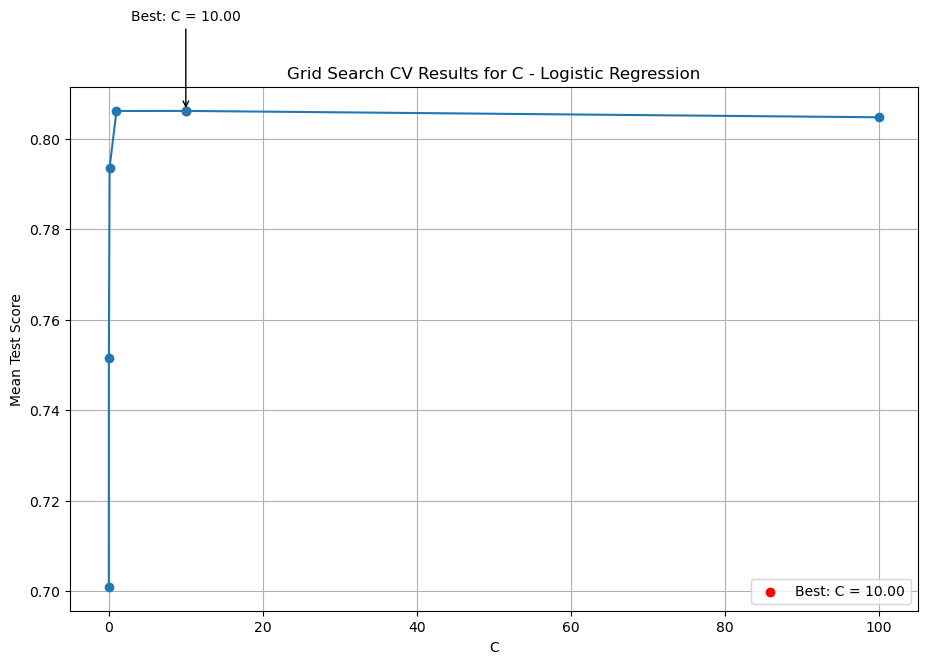

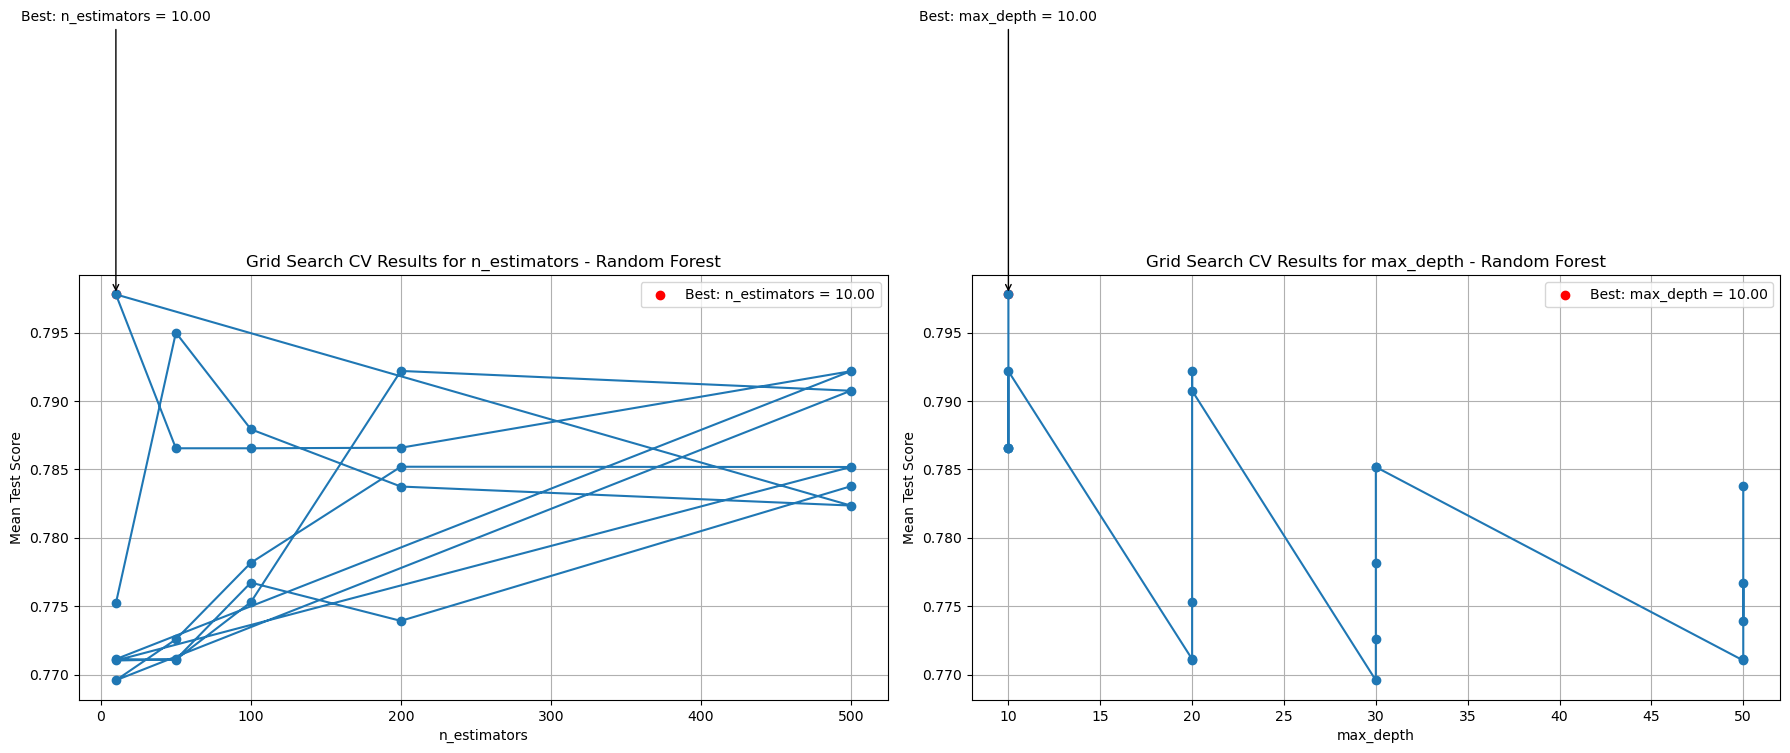

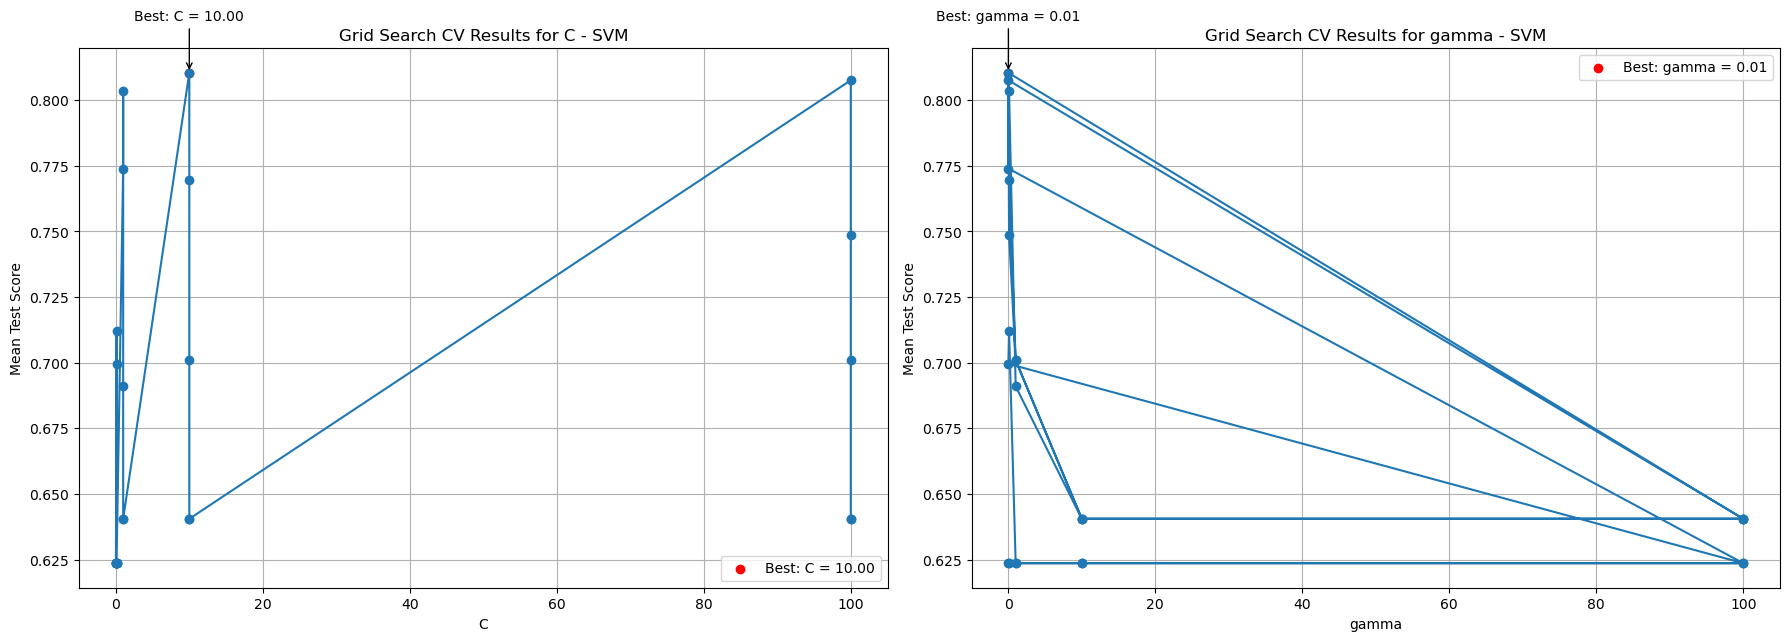

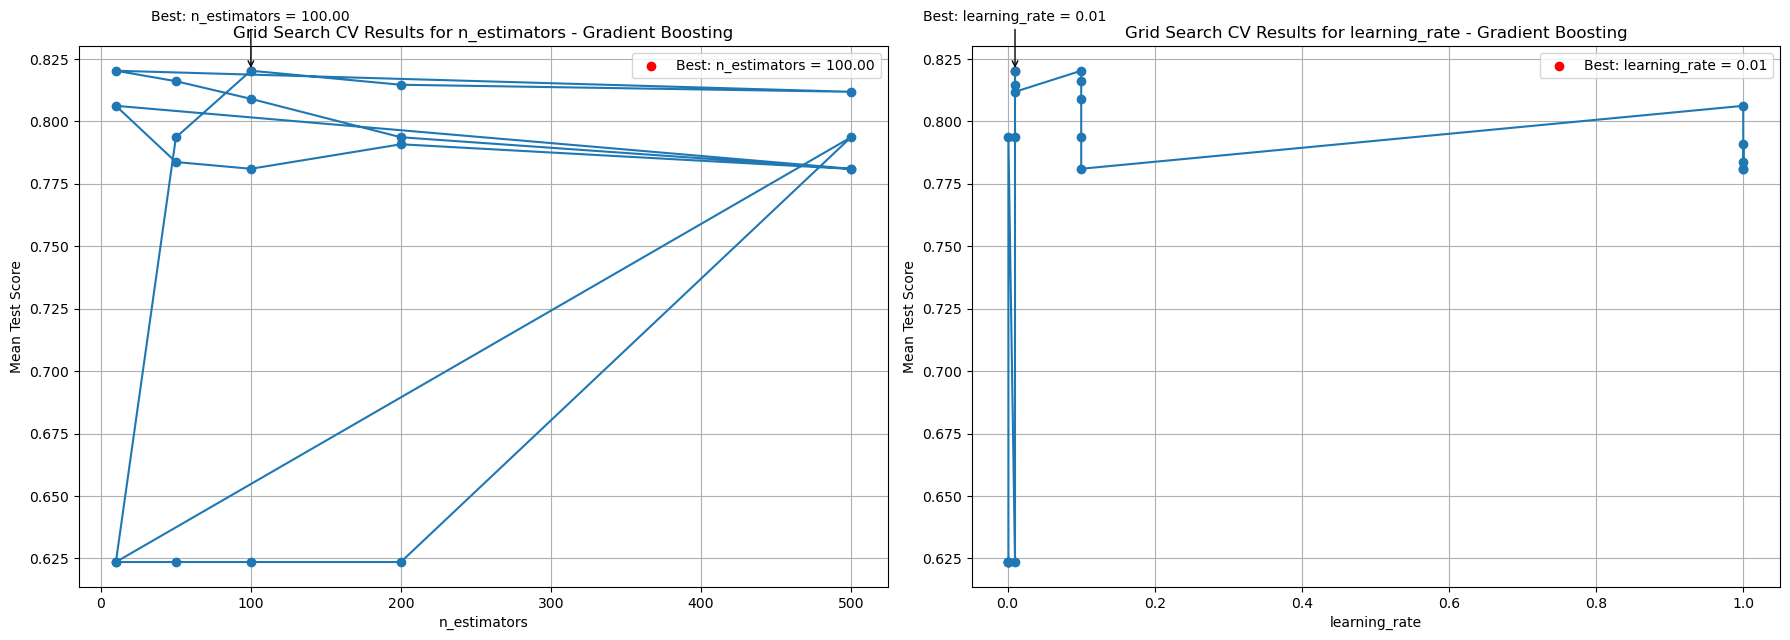

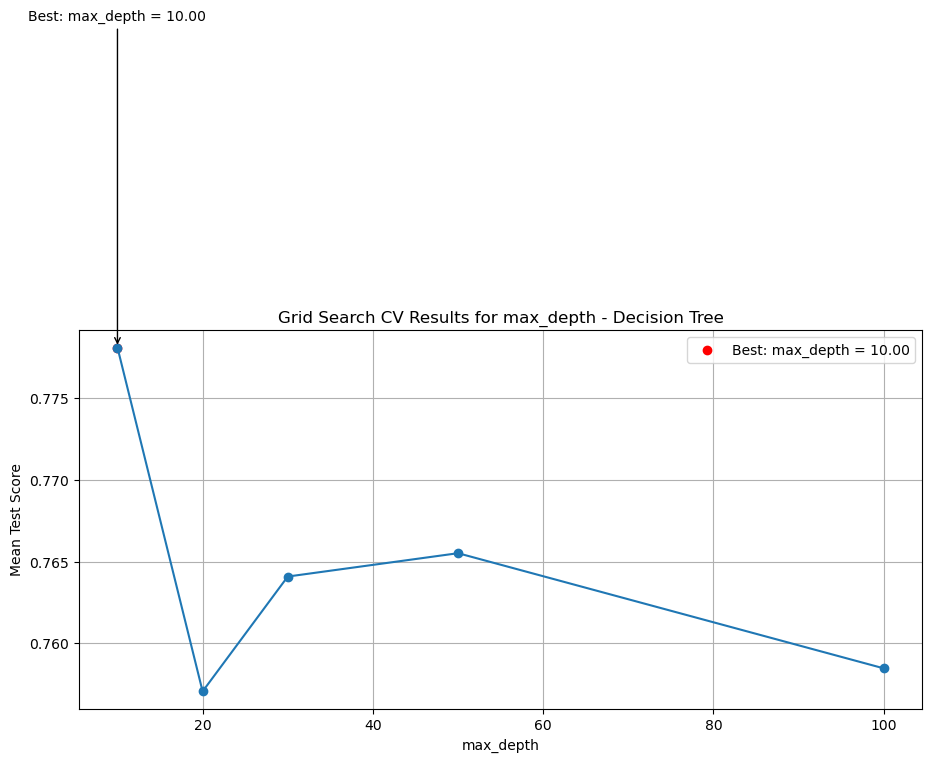

Model                               Best Parameters  \
0  Logistic Regression                                     {'C': 10}   
1        Random Forest         {'max_depth': 10, 'n_estimators': 10}   
2                  SVM                      {'C': 10, 'gamma': 0.01}   
3    Gradient Boosting  {'learning_rate': 0.01, 'n_estimators': 100}   
4        Decision Tree                             {'max_depth': 10}   

   Best Score (CV)  Validation Score  
0         0.806123          0.804469  
1         0.797790          0.798883  
2         0.810368          0.821229  
3         0.820227          0.798883  
4         0.778091          0.793296

In [116]:
# Train and evaluate models
results, evaluation_df = train_and_evaluate_models(models, X_train, y_train, X_val, y_val, param_grids, scoring='accuracy', cv=10)
evaluation_df

We can see that SVM gives us the best Validation score, meaning SVM works best with new Data.

In [117]:
best_model_row = evaluation_df.loc[evaluation_df['Validation Score'].idxmax()]
best_model_name = best_model_row['Model']
best_validation_score = best_model_row['Validation Score']

best_model = models[best_model_name]

print("Best Model: ", best_model_name)
print("Best Validation Score: {:.4f}" .format(best_validation_score))
best_model

Best Model:  SVM
Best Validation Score: 0.8212


SVC(C=10, gamma=0.01)

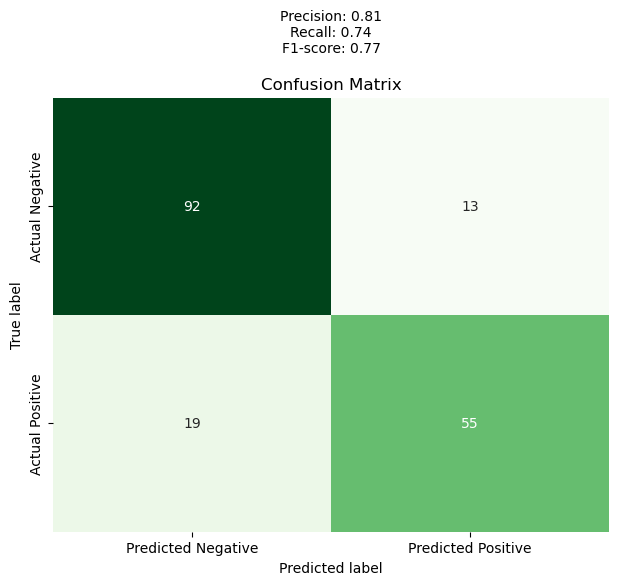

Train Accuracy: 0.8272
Validation Accuracy: 0.8212


(0.827247191011236,
 0.8212290502793296,
 0.8088235294117647,
 0.7432432432432432,
 0.7746478873239436)

In [118]:
evaluate_best_model(best_model, X_train, y_train, X_val, y_val)

## Lasso and Ridge Regularization

In [119]:
# Creating a Lasso Regularization model
lasso_model = Lasso(alpha=0.1)
# Creating a Ridge Regularization model
ridge_model = Ridge(alpha=0.1)

# Cross-validation to plot the cost function
alphas = np.logspace(-4, 4, 100)  # Range of alpha values for cross-validation
scores_lasso = []
scores_ridge = []

## 10-fold Cross Validation using initial Hyper Parameters

In order to tune Performance in every model, we'll have multiple values of the hyper paramaters and find the values that give us the best cross validation score, which in this case is accuracy scores:

In [120]:
for alpha in alphas:
    lasso_model.alpha = alpha
    cv_scores_lasso = cross_val_score(lasso_model, X_train, y_train, cv=10)  # 10-fold cross-validation
    scores_lasso.append(np.mean(cv_scores_lasso))

    ridge_model.alpha = alpha
    cv_scores_ridge = cross_val_score(ridge_model, X_train, y_train, cv=10)  # 10-fold cross-validation
    scores_ridge.append(np.mean(cv_scores_ridge))

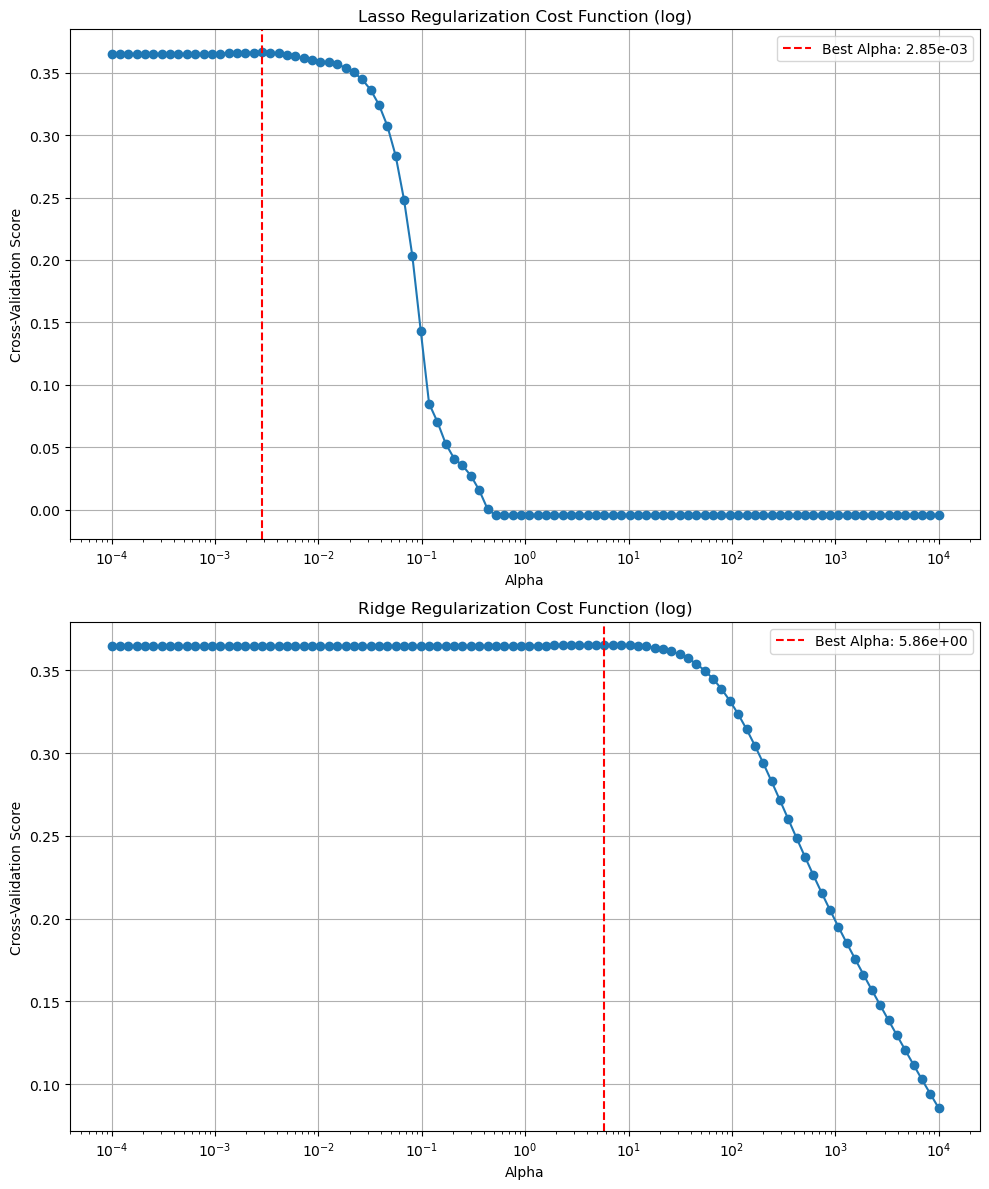

In [121]:
# Finding the best alpha value
best_alpha_lasso = alphas[np.argmax(scores_lasso)]
best_alpha_ridge = alphas[np.argmax(scores_ridge)]

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plotting the cost function for Lasso Regularization
axs[0].plot(alphas, scores_lasso, '-o')
axs[0].set_xlabel('Alpha')
axs[0].set_ylabel('Cross-Validation Score')
axs[0].set_title('Lasso Regularization Cost Function (log)')
axs[0].set_xscale('log')
axs[0].grid(True)

# Highlighting the best alpha value for Lasso Regularization
axs[0].axvline(x=best_alpha_lasso, color='r', linestyle='--', label='Best Alpha: {:.2e}'.format(best_alpha_lasso))
axs[0].legend()

# Plotting the cost function for another model (assuming you have another set of data)
axs[1].plot(alphas, scores_ridge, '-o')  # Replace scores_another_model with your actual scores
axs[1].set_xlabel('Alpha')
axs[1].set_ylabel('Cross-Validation Score')
axs[1].set_title('Ridge Regularization Cost Function (log)')
axs[1].set_xscale('log')
axs[1].grid(True)

# Highlighting the best alpha value for the another model
axs[1].axvline(x=best_alpha_ridge, color='r', linestyle='--', label='Best Alpha: {:.2e}'.format(best_alpha_ridge))
axs[1].legend()

# Adjust layout
plt.tight_layout()

plt.show()

After tuning, we fit the hyperparameters into the model and fit the trained data to this model:

In [122]:
# Training the model with the best alpha
lasso_model.alpha = best_alpha_lasso
lasso_model.fit(X_train, y_train)

# Training the model with the best alpha
ridge_model.alpha = best_alpha_ridge
ridge_model.fit(X_train, y_train)

# Predictions on train and validation data
train_predictions_lasso = lasso_model.predict(X_train)
train_predictions_ridge = ridge_model.predict(X_train)
val_predictions_lasso = lasso_model.predict(X_val)
val_predictions_ridge = ridge_model.predict(X_val)

# Accuracy metrics
train_accuracy_lasso = accuracy_score(y_train, np.round(train_predictions_lasso))
train_accuracy_ridge = accuracy_score(y_train, np.round(train_predictions_ridge)) # Round predictions to 0 or 1 for binary classification
val_accuracy_lasso = accuracy_score(y_val, np.round(val_predictions_lasso))
val_accuracy_ridge = accuracy_score(y_val, np.round(val_predictions_ridge))

print("Train Accuracy: \nLasso - {:.4f}" .format(train_accuracy_lasso) ,"\nRidge - {:.4f} \n" .format(train_accuracy_ridge))
print("Validation Accuracy: \nLasso - {:.4f}" .format(val_accuracy_lasso) ,"\nRidge - {:.4f} " .format(val_accuracy_ridge))

Train Accuracy: 
Lasso - 0.7978 
Ridge - 0.8020 

Validation Accuracy: 
Lasso - 0.7989 
Ridge - 0.7933 


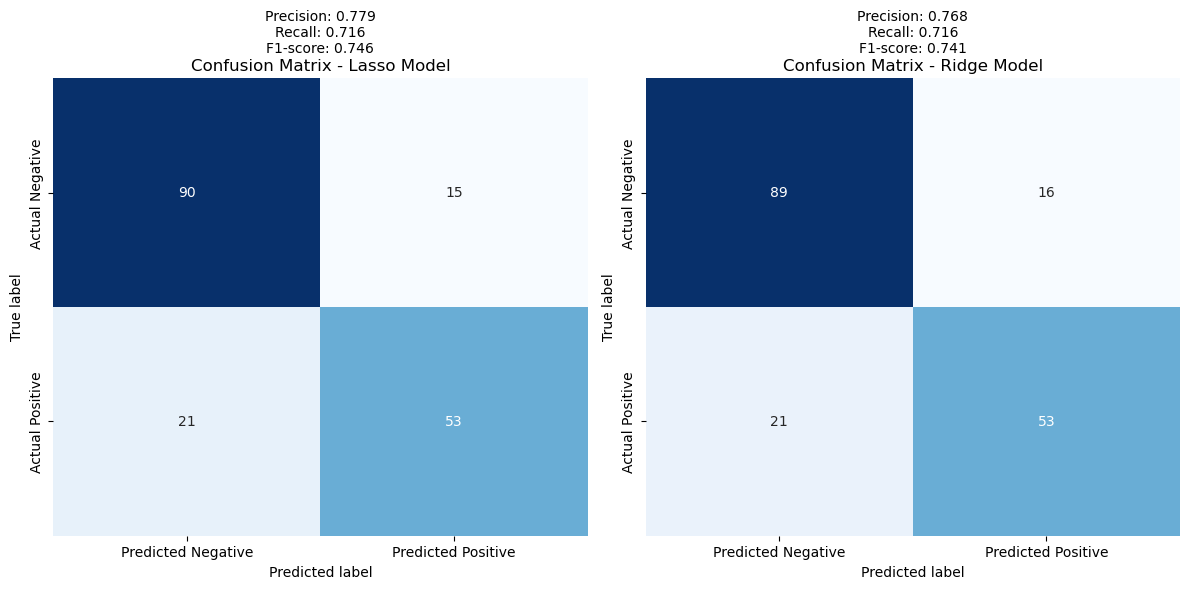

In [123]:
# Confusion matrix for Lasso model
conf_matrix_lasso = confusion_matrix(y_val, np.round(val_predictions_lasso))

# Confusion matrix for Ridge model
conf_matrix_ridge = confusion_matrix(y_val, np.round(val_predictions_ridge))

# Calculate precision, recall, and F1-score for Lasso Model
precision_lasso = precision_score(y_val, np.round(val_predictions_lasso))
recall_lasso = recall_score(y_val, np.round(val_predictions_lasso))
f1_lasso = f1_score(y_val, np.round(val_predictions_lasso))

# Calculate precision, recall, and F1-score for Ridge Model
precision_ridge = precision_score(y_val, np.round(val_predictions_ridge))
recall_ridge = recall_score(y_val, np.round(val_predictions_ridge))
f1_ridge = f1_score(y_val, np.round(val_predictions_ridge))

# Plot confusion matrix with additional metrics for Lasso Model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_lasso, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title("Confusion Matrix - Lasso Model")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.text(0.5, 1.1, f"Precision: {precision_lasso:.3f}\nRecall: {recall_lasso:.3f}\nF1-score: {f1_lasso:.3f}",
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Plot confusion matrix with additional metrics for Ridge Model
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_ridge, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title("Confusion Matrix - Ridge Model")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.text(0.5, 1.1, f"Precision: {precision_ridge:.3f}\nRecall: {recall_ridge:.3f}\nF1-score: {f1_ridge:.3f}",
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# Gradient Boosting

Tuning Boosting Hyperparameters using Grid search 10-fold Cross Validation:

In [124]:
# Define hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Create a Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a new Gradient Boosting Classifier with the best hyperparameters
best_gb_classifier = GradientBoostingClassifier(**best_params, random_state=42)
best_gb_classifier.fit(X_train, y_train)

# Plotting the cost function
results = grid_search.cv_results_
scores = results['mean_test_score']
params = results['params']


### Results and Fitting model:

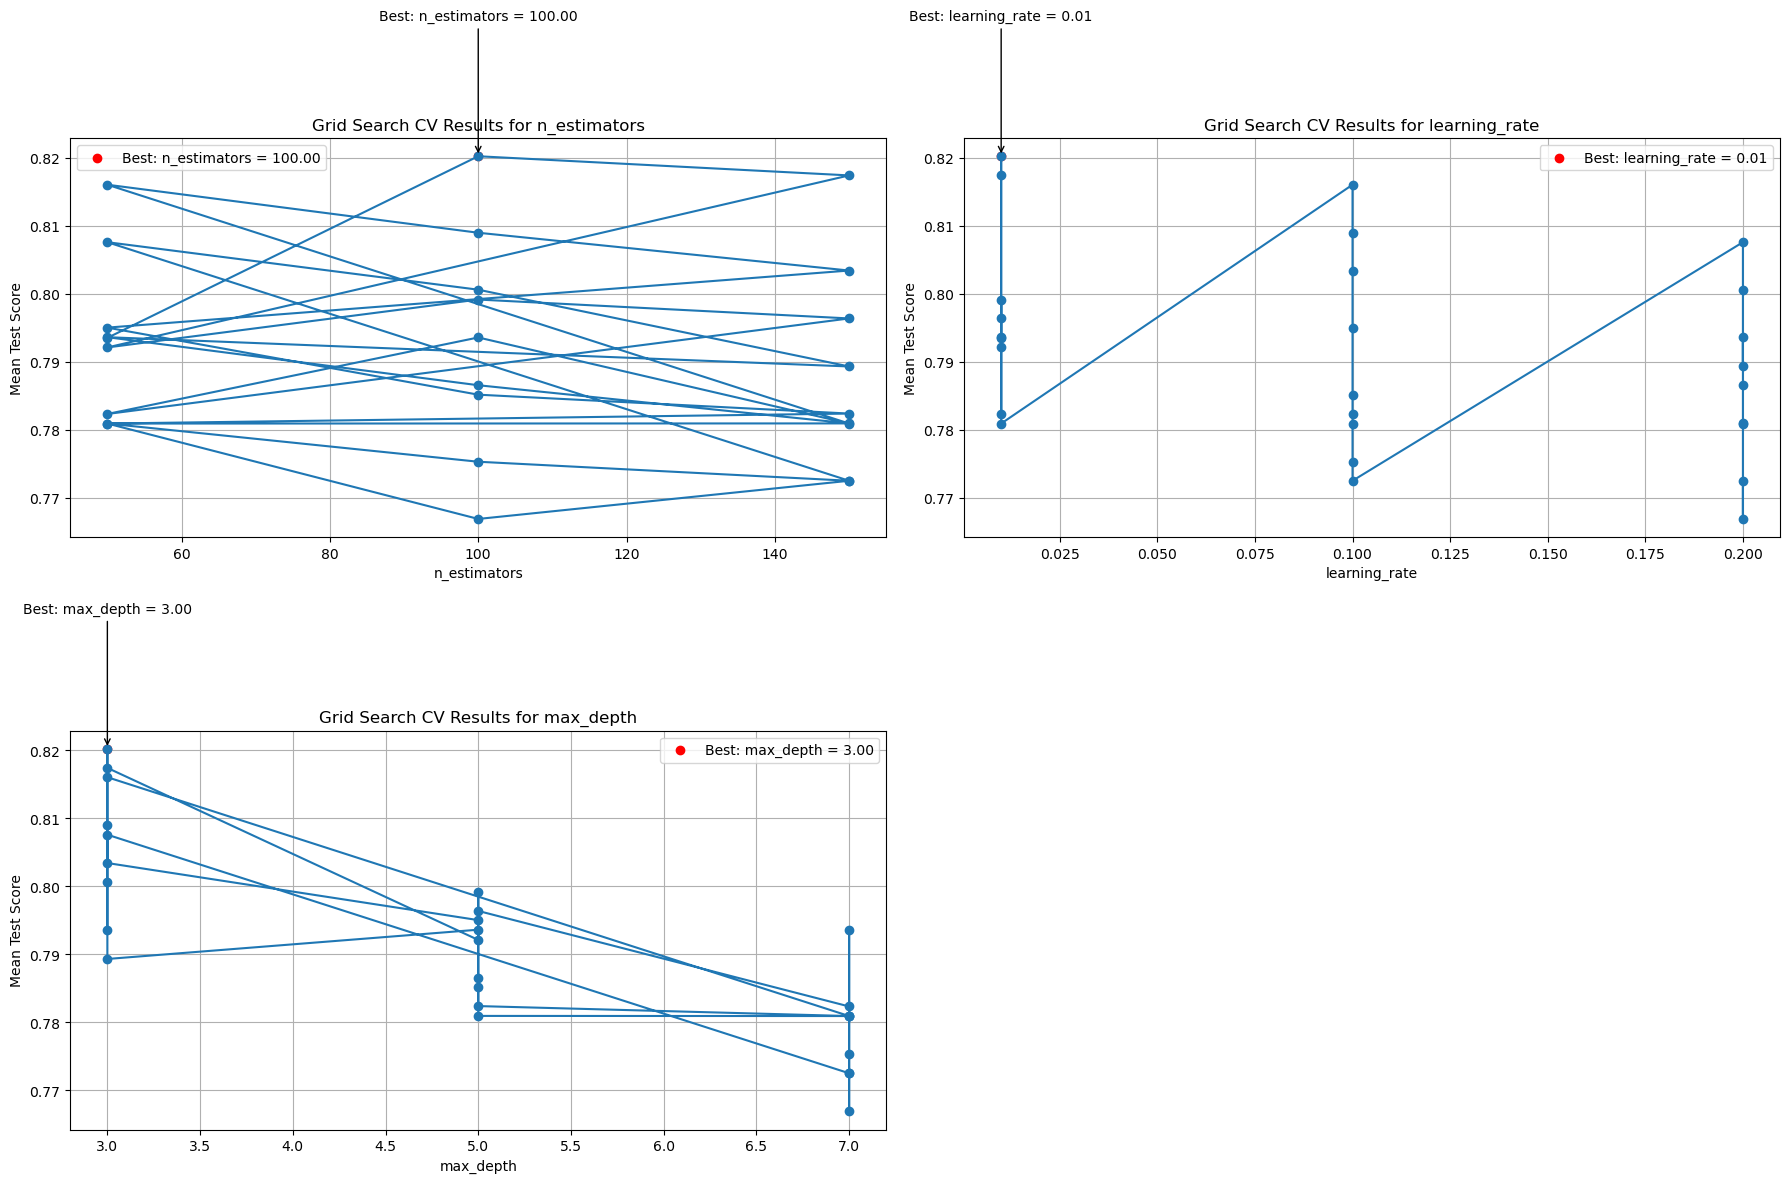

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Train Accuracy: 0.8258
Validation Accuracy: 0.7989


In [125]:
plt.figure(figsize=(18, 12))

for i, param_name in enumerate(param_grid.keys()):
    plt.subplot(2, 2, i + 1)
    param_values = [param[param_name] for param in params]
    plt.plot(param_values, scores, marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Mean Test Score')
    plt.title('Grid Search CV Results for {}'.format(param_name))
    plt.grid(True)

  # Marking the best parameter value
    best_value = best_params[param_name]
    best_score = grid_search.best_score_
    plt.scatter(best_value, best_score, color='red', label='Best: {} = {:.2f}'.format(param_name, best_value))
    plt.annotate('Best: {} = {:.2f}'.format(param_name, best_value), xy=(best_value, best_score), xytext=(best_value, best_score + 0.02),
                 arrowprops=dict(facecolor='black', arrowstyle='->'), horizontalalignment='center')
    plt.legend()

plt.tight_layout()
plt.show()

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Predictions on validation data
train_predictions = best_gb_classifier.predict(X_train)

# Predictions on validation data
val_predictions = best_gb_classifier.predict(X_val)

# Accuracy metrics
train_accuracy = accuracy_score(y_train, np.round(train_predictions))
val_accuracy = accuracy_score(y_val, np.round(val_predictions))

print("Train Accuracy: {:.4f}" .format(train_accuracy))
print("Validation Accuracy: {:.4f}" .format(val_accuracy))

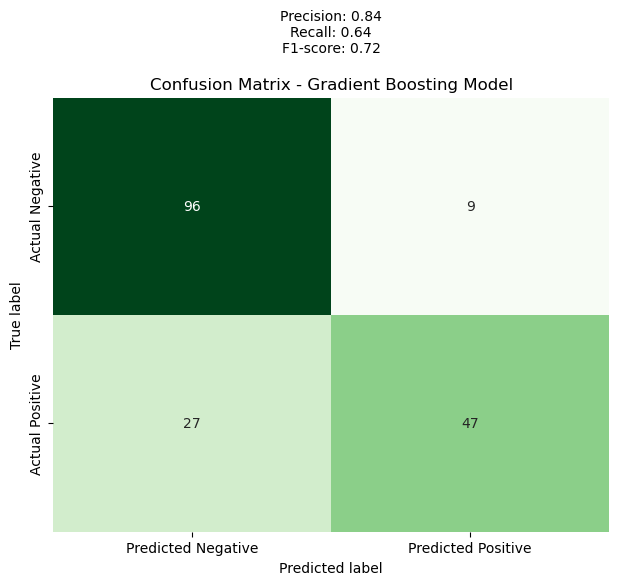

In [126]:
# Confusion matrix for Gradient Boosting Model
conf_matrix = confusion_matrix(y_val, np.round(val_predictions))

# Calculate precision, recall, and F1-score for Gradient Boosting Model
precision_gb = precision_score(y_val, np.round(val_predictions))
recall_gb = recall_score(y_val, np.round(val_predictions))
f1_gb = f1_score(y_val, np.round(val_predictions))

# Plot confusion matrix with additional metrics for Gradient Boosting Model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title("Confusion Matrix - Gradient Boosting Model")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.text(0.5, 1.15, f"Precision: {precision_gb:.2f}\nRecall: {recall_gb:.2f}\nF1-score: {f1_gb:.2f}",
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.tight_layout()
plt.show()

# SVM

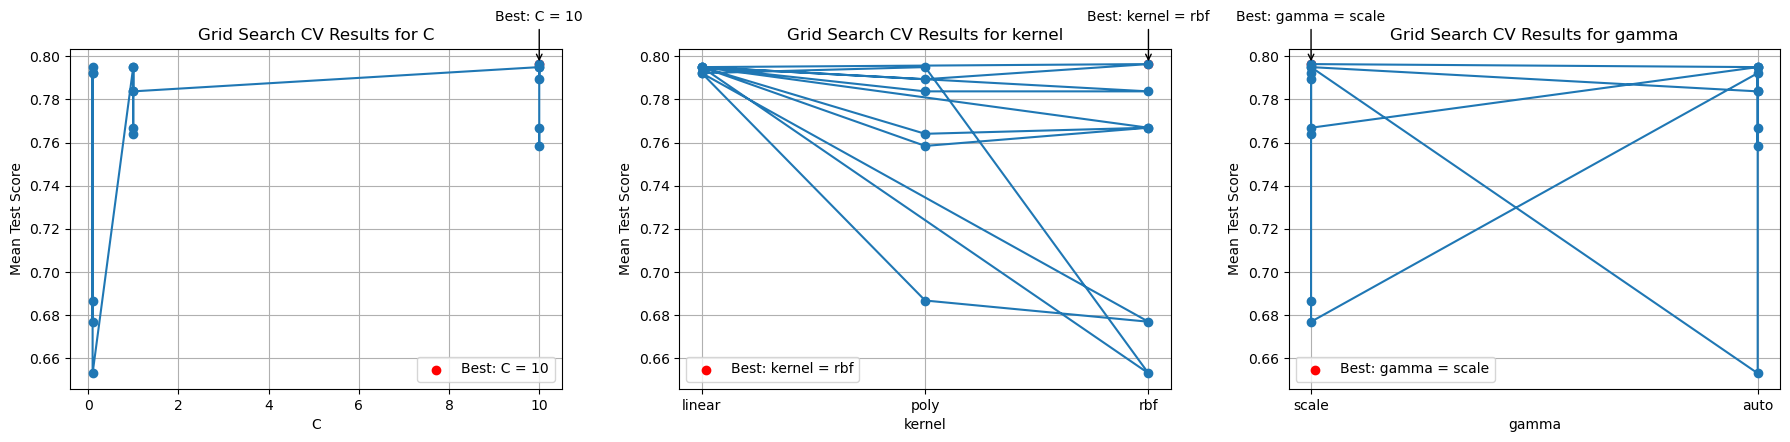

In [127]:
# Define hyperparameters grid for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Create a Support Vector Classifier (SVC)
svm_classifier = SVC(random_state=42)

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=svm_classifier, 
                           param_grid=param_grid, cv=iterations+1, 
                           scoring='accuracy', n_jobs=16)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a new Support Vector Classifier with the best hyperparameters
best_svm_classifier = SVC(**best_params, random_state=42)
best_svm_classifier.fit(X_train, y_train)

# Plotting the results
results = grid_search.cv_results_
scores = results['mean_test_score']
params = results['params']

plt.figure(figsize=(18, 12))

for i, param_name in enumerate(param_grid.keys()):
    plt.subplot(3, 3, i + 1)
    param_values = [param[param_name] for param in params]
    plt.plot(param_values, scores, marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Mean Test Score')
    plt.title('Grid Search CV Results for {}'.format(param_name))
    plt.grid(True)

    # Marking the best parameter value
    best_value = best_params[param_name]
    best_score = grid_search.best_score_
    plt.scatter(best_value, best_score, color='red', label='Best: {} = {}'.format(param_name, best_value))
    plt.annotate('Best: {} = {}'.format(param_name, best_value), xy=(best_value, best_score), xytext=(best_value, best_score + 0.02),
                 arrowprops=dict(facecolor='black', arrowstyle='->'), horizontalalignment='center')
    plt.legend()

plt.tight_layout()

In [128]:
plt.show()

In [129]:
# Predictions on training data
train_predictions = best_svm_classifier.predict(X_train)

# Predictions on validation data
val_predictions = best_svm_classifier.predict(X_val)

# Accuracy metrics
train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)

And the best hyperparameters are: 

In [130]:
print("Best Hyperparameters:", best_params)
print("Train Accuracy: {:.4f}" .format(train_accuracy))
print("Validation Accuracy: {:.4f}" .format(val_accuracy))

Best Hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Train Accuracy: 0.8371
Validation Accuracy: 0.8268


*we added more variety of values in the parameters, but it took longer with no impact to the accuracy, so we stayed with these values.

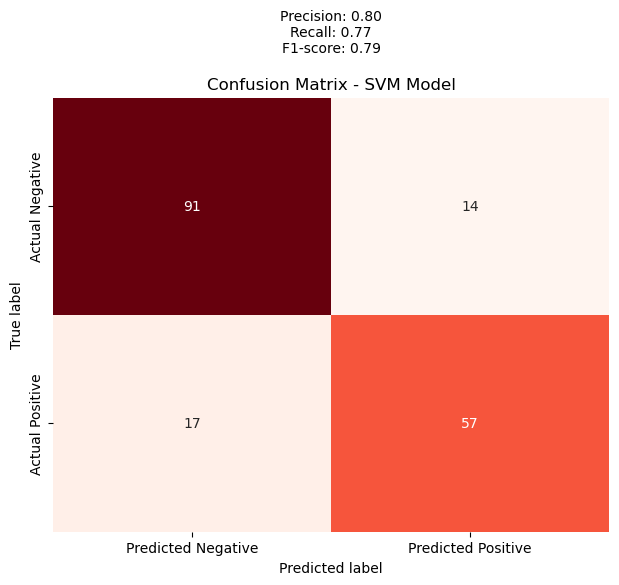

In [131]:
# Confusion matrix for SVM Model
conf_matrix = confusion_matrix(y_val, np.round(val_predictions))

# Calculate precision, recall, and F1-score for SVM Model
precision_svm = precision_score(y_val, np.round(val_predictions))
recall_svm = recall_score(y_val, np.round(val_predictions))
f1_svm = f1_score(y_val, np.round(val_predictions))

# Plot confusion matrix with additional metrics for SVM Model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title("Confusion Matrix - SVM Model")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.text(0.5, 1.15, f"Precision: {precision_svm:.2f}\nRecall: {recall_svm:.2f}\nF1-score: {f1_svm:.2f}",
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.tight_layout()

In [132]:
plt.show()

# Test input data for submission

In [133]:
passenger_df_test = passenger_df[passenger_df.Survived == -1].drop("Survived", axis=1)
passenger_df_test.head(10)

Pclass  Sex  Age  Parch  Fare  Embarked  Words_Count  \
PassengerId                                                         
892               3    1  4.0      0     1         2            3   
893               3    0  5.0      0     1         0            5   
894               2    1  5.0      0     1         2            4   
895               3    1  2.0      0     1         0            3   
896               3    0  1.0      1     2         0            6   
897               3    1  0.0      0     1         0            4   
898               3    0  3.0      0     1         2            3   
899               2    1  2.0      1     4         0            4   
900               3    0  1.0      0     1         1            6   
901               3    1  1.0      0     4         0            4   

             cabin_multiple  cabin_deck  FamilySize  IsAlone  Age*Class  
PassengerId                                                              
892                       0           0           1        1       12.0  
893                       0           0           2        0       15.0  
894                       0           0           1        1       10.0  
895                       0           0           1        1        6.0  
896                       0           0           3        0        3.0  
897                       0           0           1        1        0.0  
898                       0           0           1        1        9.0  
899                       0           0           3        0        4.0  
900                       0           0           1        1        3.0  
901                       0           0           3        0        3.0

In [134]:
predictions = best_model.predict(passenger_df_test)
#predictions = best_svm_classifier.predict(passenger_df_test)
#predictions = best_gb_classifier.predict(passenger_df_test)
#predictions = lasso_model.predict(passenger_df_test)
#predictions = ridge_model.predict(passenger_df_test)
predictions = predictions.astype(int)

# Convert predictions into binary output
#binary_predictions = (predictions >= 0.5).astype(int)

output = pd.DataFrame({'PassengerId': passenger_df_test.index, 'Survived': predictions})
#output = pd.DataFrame({'PassengerId': passenger_df_test.index, 'Survived': binary_predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [135]:
output.sample(10)

PassengerId  Survived
341         1233         0
316         1208         0
183         1075         0
45           937         0
310         1202         0
367         1259         1
202         1094         0
294         1186         0
355         1247         0
362         1254         1